In [3]:
## packages
!pip install -q kaggle
!pip install -q pandas
!pip install -q scikit-learn
!pip install -q numpy
!pip install -q Matplotlib
!pip install -q seaborn

In [5]:
# !mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !kaggle competitions download -c optiver-trading-at-the-close
# !unzip optiver-trading-at-the-close.zip
# !ls

#### **Anomalies and Cleaning**

Take a look at the training data. There may be anomalies in the data that you may need
to factor in before you start on the other tasks. Make a note of the anomalies that you
notice. Clean the data first to handle these issues if it will improve your analysis.
Explain what you did to clean the data (in bulleted form) or explain why you did not
change it to address these anomalies.


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from prettytable import PrettyTable
from scipy.cluster import hierarchy
from scipy.stats import ttest_1samp
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import HistGradientBoostingRegressor

pd.options.mode.chained_assignment = None

col_names = [
  "stock_id",
  "date_id",
  "seconds_in_bucket",
  "imbalance_size",
  "imbalance_buy_sell_flag",
  "reference_price",
  "matched_size",
  "far_price",
  "near_price",
  "bid_price",
  "bid_size",
  "ask_price",
  "ask_size",
  "wap",
  "target",
  "time_id",
  "row_id"
]
dtypes = {
  "stock_id": np.int32,
  "date_id":np.int32,
  "seconds_in_bucket":np.int32,
  "imbalance_size":np.float32,
  "imbalance_buy_sell_flag":np.int32,
  "reference_price":np.float32,
  "matched_size":np.float32,
  "far_price":np.float32,
  "near_price":np.float32,
  "bid_price":np.float32,
  "bid_size":np.float32,
  "ask_price":np.float32,
  "ask_size":np.float32,
  "wap":np.float32,
  "target":np.float32,
  "time_id":np.int32,
  "row_id": "string",
}

I specified column names and data types in the code to optimize memory usage and prevent potential RAM crashes. I used np.int32 for integer columns and np.float32 for float columns to conserve memory.

**Reading the data**

In [7]:
data = pd.read_csv("train.csv", dtype=dtypes) # reading a CSV file into a Pandas DataFrame with specified data types.
data # displaying the contents of the DataFrame.

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3.180603e+06,1,0.999812,13380277.00,NaN,NaN,0.999812,60651.500000,1.000026,8493.030273,1.000000,-3.029704,0,0_0_0
1,1,0,0,1.666039e+05,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.040039,1.000660,20605.089844,1.000000,-5.519986,0,0_0_1
2,2,0,0,3.028799e+05,-1,0.999561,1819368.00,NaN,NaN,0.999403,37956.000000,1.000298,18995.000000,1.000000,-8.389950,0,0_0_2
3,3,0,0,1.191768e+07,-1,1.000171,18389746.00,NaN,NaN,0.999999,2324.899902,1.000214,479032.406250,1.000000,-4.010201,0,0_0_3
4,4,0,0,4.475500e+05,-1,0.999532,17860614.00,NaN,NaN,0.999394,16485.539062,1.000016,434.100006,1.000000,-7.349849,0,0_0_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,195,480,540,2.440723e+06,-1,1.000317,28280362.00,0.999734,0.999734,1.000317,32257.039062,1.000434,319862.406250,1.000328,2.310276,26454,480_540_195
5237976,196,480,540,3.495105e+05,-1,1.000643,9187699.00,1.000129,1.000386,1.000643,205108.406250,1.000900,93393.070312,1.000819,-8.220077,26454,480_540_196
5237977,197,480,540,0.000000e+00,0,0.995789,12725436.00,0.995789,0.995789,0.995789,16790.660156,0.995883,180038.312500,0.995797,1.169443,26454,480_540_197
5237978,198,480,540,1.000899e+06,1,0.999210,94773272.00,0.999210,0.999210,0.998970,125631.718750,0.999210,669893.000000,0.999008,-1.540184,26454,480_540_198


**Checking basic information of the DataFrame**

In [8]:
data.info() # printing information about the dataframe.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5237980 entries, 0 to 5237979
Data columns (total 17 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   stock_id                 int32  
 1   date_id                  int32  
 2   seconds_in_bucket        int32  
 3   imbalance_size           float32
 4   imbalance_buy_sell_flag  int32  
 5   reference_price          float32
 6   matched_size             float32
 7   far_price                float32
 8   near_price               float32
 9   bid_price                float32
 10  bid_size                 float32
 11  ask_price                float32
 12  ask_size                 float32
 13  wap                      float32
 14  target                   float32
 15  time_id                  int32  
 16  row_id                   string 
dtypes: float32(11), int32(5), string(1)
memory usage: 359.7 MB


In [9]:
data.drop(columns=['row_id'], inplace=True) # removing the 'row_id' column from the DataFrame in place.

I got rid of the row_id because it didn't give us any useful information for our modeling.

**Treatment of Missing Values**

In [10]:
data.isnull().sum().sort_values(ascending=False)  # counting and sorting the number of missing values in each column.

far_price                  2894342
near_price                 2857180
imbalance_size                 220
reference_price                220
matched_size                   220
bid_price                      220
ask_price                      220
wap                            220
target                          88
stock_id                         0
date_id                          0
seconds_in_bucket                0
imbalance_buy_sell_flag          0
bid_size                         0
ask_size                         0
time_id                          0
dtype: int64

In [11]:
nan_imbalance_size = data[data['imbalance_size'].isna()]  # filter rows where 'imbalance_size' is NaN.
rows_with_nan = nan_imbalance_size.index.tolist()  # get the indices of rows with NaN 'imbalance_size'.

# iterate through columns, find rows with NaN values, and print the count if they share common rows with 'imbalance_size'.
for column in data.columns:
    if column != 'imbalance_size':
        nan_column = data[data[column].isna()]  # filter rows with NaN in the current column.
        nan_rows = nan_column.index.tolist()  # get the indices of rows with NaN in the current column.
        common_rows = set(rows_with_nan).intersection(nan_rows)  # find common rows with NaN values.
        if len(common_rows) > 0:
            print(f"rows with NaN in {column} column: {len(common_rows)}")  # print the count of common rows.

rows with NaN in reference_price column: 220
rows with NaN in matched_size column: 220
rows with NaN in far_price column: 220
rows with NaN in near_price column: 220
rows with NaN in bid_price column: 220
rows with NaN in ask_price column: 220
rows with NaN in wap column: 220
rows with NaN in target column: 88


Here I'm finding rows in dataset where the 'imbalance_size' column has missing (NaN) values. I create a subset of data containing these rows with missing 'imbalance_size.' Then, I go through all other columns in the dataset, except for 'imbalance_size,' and check if there are common rows with NaN values in both the 'imbalance_size' column and the currently examined column. If common rows exist, I print the count of such rows along with the column name, helping me understand the relationship between missing 'imbalance_size' values and missing values in other columns. This analysis is useful for identifying potential data issues or patterns related to missing data.

In [12]:
data = data.dropna(subset=['imbalance_size'])  # remove rows with NaN values in the 'imbalance_size' column.

Dropping rows with missing "imbalance_size" values is justified over imputation in stock market analysis because, in this specific case, the number of such NaN rows was only 220 out of a total of 5.5 million rows. Imputing data for such a small proportion of the dataset would not significantly impact the overall dataset, but it could introduce artificial information and potentially skew the analysis, making it more sensible to preserve the integrity and accuracy of the vast majority of the data by excluding those few rows.

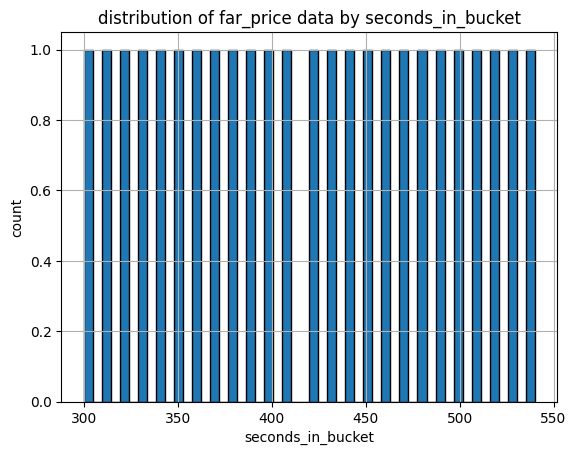

number of unique stock IDs: 200
number of unique date IDs: 481


In [13]:
# filter rows where far_price is not NaN
filtered_data = data[~data.far_price.isna()]

# get unique seconds_in_bucket values
unique_seconds = filtered_data.seconds_in_bucket.unique()

# plot a histogram of the distribution of available far_price data in seconds_in_bucket
plt.hist(unique_seconds, bins=50, edgecolor='k')
plt.title('distribution of far_price data by seconds_in_bucket')
plt.xlabel('seconds_in_bucket')
plt.ylabel('count')
plt.grid(True)
plt.show()

# calculate the number of unique stock_ids and date_ids
unique_stock_ids = len(filtered_data.stock_id.unique())
unique_date_ids = len(filtered_data.date_id.unique())

# print the results
print(f"number of unique stock IDs: {unique_stock_ids}")
print(f"number of unique date IDs: {unique_date_ids}")

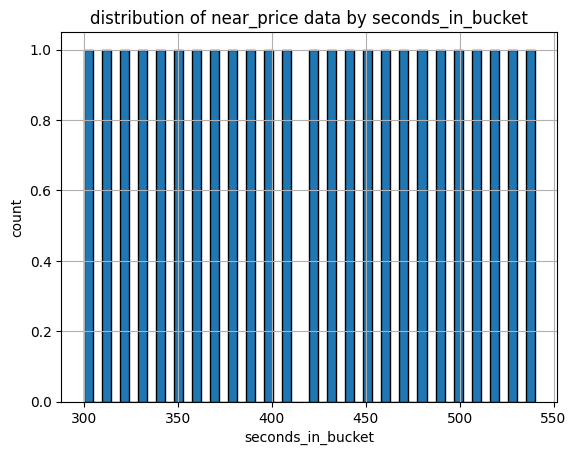

number of unique stock IDs: 200
number of unique date IDs: 481


In [14]:
# filter rows where near_price is not NaN
filtered_data = data[~data.near_price.isna()]

# get unique seconds_in_bucket values
unique_seconds = filtered_data.seconds_in_bucket.unique()

# plot a histogram of the distribution of available near_price data in seconds_in_bucket
plt.hist(unique_seconds, bins=50, edgecolor='k')
plt.title('distribution of near_price data by seconds_in_bucket')
plt.xlabel('seconds_in_bucket')
plt.ylabel('count')
plt.grid(True)
plt.show()

# calculate the number of unique stock_ids and date_ids
unique_stock_ids = len(filtered_data.stock_id.unique())
unique_date_ids = len(filtered_data.date_id.unique())

# print the results
print(f"number of unique stock IDs: {unique_stock_ids}")
print(f"number of unique date IDs: {unique_date_ids}")

The histograms show the distribution of available "far_price" and "near_price" data by "seconds_in_bucket." Both visualizations reveal that the respective price data starts to exist after approximately 300 seconds, indicating a common pattern across all stocks and dates.

It appears that "far_price" and "near_price" data become available in the dataset after around 300 seconds into the trading session, suggesting a consistent data collection practice. Additionally, the analysis reveals that there is available price data for every stock and date represented in the dataset for both "far_price" and "near_price".

In [15]:
# list of imputation strategies to evaluate
imputation_strategies = ['mean', 'median', 'most_frequent', 'constant']
average_scores = []


model = LinearRegression()

# iterate over each imputation strategy and evaluate model performance
for strategy in imputation_strategies:
    # make a copy of the original data to avoid modifying it
    data_copy = data.copy()

    # impute missing values in both the 'far_price' and 'near_price' columns using the current strategy
    imputer = SimpleImputer(strategy=strategy)
    data_copy[['far_price', 'near_price']] = imputer.fit_transform(data_copy[['far_price', 'near_price']])

    X = data_copy.drop(columns=['target'])
    y = data_copy['target']

    # perform cross-validation and evaluate model performance using mae
    scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')

    del data_copy

    average_score = -np.mean(scores)

    average_scores.append(average_score)

    # print the strategy and its corresponding performance metric
    print(f"imputation strategy: {strategy}")
    print(f"average cross-validation mse: {average_score}")
    print()

# select the best imputation strategy based on performance
best_strategy = imputation_strategies[np.argmin([average_score for average_score in average_scores])]
print(f"best imputation strategy: {best_strategy}")

imputation strategy: mean
average cross-validation mse: 6.324294255545441

imputation strategy: median
average cross-validation mse: 6.324297894070874

imputation strategy: most_frequent
average cross-validation mse: 6.324299585119529

imputation strategy: constant
average cross-validation mse: 6.324200364507776

best imputation strategy: constant


In [16]:
# initialize the imputer with the best strategy
imputer = SimpleImputer(strategy=best_strategy)

# impute missing values in 'far_price' and 'near_price' columns
columns_to_impute = ['far_price', 'near_price']
data.loc[:, columns_to_impute] = imputer.fit_transform(data.loc[:, columns_to_impute]).copy()

imputed_data = data

<ipython-input-16-715fd1414242>:6: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.loc[:, columns_to_impute] = imputer.fit_transform(data.loc[:, columns_to_impute]).copy()


I chose to impute missing values in the "far_price" and "near_price" columns due to their significant number of null values, accounting for approximately 50% of the data in each column. Removing rows with missing values would have resulted in a substantial loss of data, potentially compromising the integrity of the analysis. Imputation allowed me to retain the available data while filling in the gaps with estimated values based on the chosen imputation strategy, in this case, filling with constant value (0) strategy. This approach ensures that the dataset remains complete and usable for subsequent analysis, minimizing any potential bias that could arise from data removal.

In [17]:
imputed_data

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id
0,0,0,0,3.180603e+06,1,0.999812,13380277.00,0.000000,0.000000,0.999812,60651.500000,1.000026,8493.030273,1.000000,-3.029704,0
1,1,0,0,1.666039e+05,-1,0.999896,1642214.25,0.000000,0.000000,0.999896,3233.040039,1.000660,20605.089844,1.000000,-5.519986,0
2,2,0,0,3.028799e+05,-1,0.999561,1819368.00,0.000000,0.000000,0.999403,37956.000000,1.000298,18995.000000,1.000000,-8.389950,0
3,3,0,0,1.191768e+07,-1,1.000171,18389746.00,0.000000,0.000000,0.999999,2324.899902,1.000214,479032.406250,1.000000,-4.010201,0
4,4,0,0,4.475500e+05,-1,0.999532,17860614.00,0.000000,0.000000,0.999394,16485.539062,1.000016,434.100006,1.000000,-7.349849,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,195,480,540,2.440723e+06,-1,1.000317,28280362.00,0.999734,0.999734,1.000317,32257.039062,1.000434,319862.406250,1.000328,2.310276,26454
5237976,196,480,540,3.495105e+05,-1,1.000643,9187699.00,1.000129,1.000386,1.000643,205108.406250,1.000900,93393.070312,1.000819,-8.220077,26454
5237977,197,480,540,0.000000e+00,0,0.995789,12725436.00,0.995789,0.995789,0.995789,16790.660156,0.995883,180038.312500,0.995797,1.169443,26454
5237978,198,480,540,1.000899e+06,1,0.999210,94773272.00,0.999210,0.999210,0.998970,125631.718750,0.999210,669893.000000,0.999008,-1.540184,26454


In [18]:
imputed_data.isnull().sum()  # checking for the presence of any remaining missing values in the imputed data.

stock_id                   0
date_id                    0
seconds_in_bucket          0
imbalance_size             0
imbalance_buy_sell_flag    0
reference_price            0
matched_size               0
far_price                  0
near_price                 0
bid_price                  0
bid_size                   0
ask_price                  0
ask_size                   0
wap                        0
target                     0
time_id                    0
dtype: int64

**Anmolaies Analysis**

In [19]:
def count_anomalies(df, z_threshold=3):
    # create a dictionary to store outlier counts for each column
    outlier_counts = {}

    # iterate over numeric columns and count anomalies
    for column in df.select_dtypes(include=[np.number]):
        z_scores = np.abs(stats.zscore(df[column]))
        anomalies = z_scores > z_threshold

        # store the count of anomalies for the current column
        outlier_counts[column] = anomalies.sum()

    return outlier_counts

In [20]:
outlier_counts = count_anomalies(imputed_data)  # count anomalies in the imputed data using the count_anomalies function.

In [21]:
# create a DataFrame to store column names and the number of anomalies.
outlier_df = pd.DataFrame(list(outlier_counts.items()), columns=["column name", "number of anomalies"])

I'm defining a function called count_anomalies that takes DataFrame as input and, by utilizing the Z-score method from the scipy.stats library, identifies and counts anomalies in numeric columns of the DataFrame. Anomalies are detected based on a specified Z-score threshold. The function returns a dictionary that records the number of anomalies found in each numeric column.

In [22]:
outlier_df

,column name,number of anomalies
0,stock_id,0
1,date_id,0
2,seconds_in_bucket,0
3,imbalance_size,63839
4,imbalance_buy_sell_flag,0
5,reference_price,75237
6,matched_size,80498
7,far_price,78
8,near_price,0
9,bid_price,76014


I'm choosing not to address the anomalies in my dataset for this specific problem because financial data, especially in stock markets, often includes extreme price movements and anomalies that are meaningful and reflective of real market dynamics. Removing anomalies could potentially lead to the loss of valuable information, and these extreme values might carry crucial insights into market behavior during volatile periods. My approach is to let the model learn from the data as-is and adapt to these extreme events, as they are integral to the overall understanding of stock price movements.

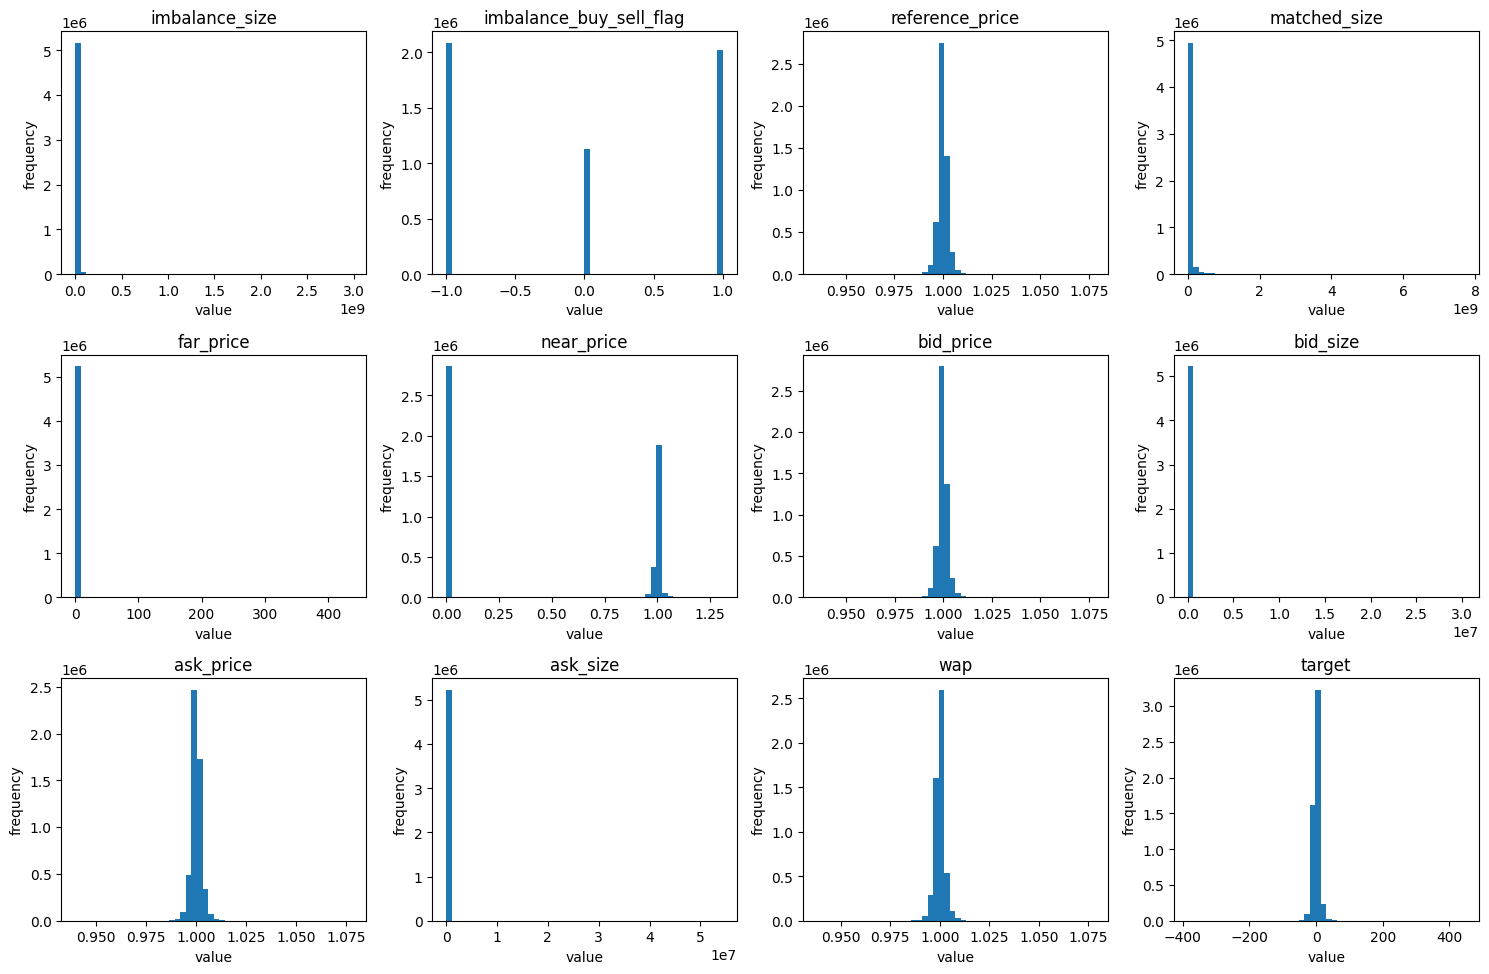

In [23]:
# columns to be visualized
numeric_columns = ['imbalance_size', 'imbalance_buy_sell_flag', 'reference_price',
                   'matched_size', 'far_price', 'near_price', 'bid_price', 'bid_size',
                   'ask_price', 'ask_size', 'wap', 'target']

num_rows = 3
num_cols = 4

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))
axes = axes.flatten()
for i, column in enumerate(numeric_columns):
    ax = axes[i]
    ax.hist(imputed_data[column], bins=50)
    ax.set_title(column)
    ax.set_xlabel("value")
    ax.set_ylabel("frequency")
plt.tight_layout()
plt.show()

I am visualizing the distributions of various numerical features in my dataset using histograms. By examining these visualizations, I aim to understand the shapes and spread of these numerical features. This exploration is essential to make an informed decision on which data scaling method, either MinMax scaler or Standard scaler, to apply in subsequent data preprocessing steps. Different scaling techniques are more suitable depending on the nature of the data distributions, and these visualizations help guide that decision.

When I looked at the correlation heatmap in Q2, I found more things to explore. So, I decided to work on the features a bit more and make sure they're all in the same scale. This is a common step in data analysis because it helps improve  model's accuracy and makes it easier to understand. By addressing potential multicollinearity and ensuring all features are on a consistent scale, I aim to enhance the model's predictive power and facilitate a more comprehensive understanding of the underlying data relationships.

#### **Pairwise correlation Table and Explanation.**

Construct a pairwise correlation table of the given variables. Use Pearson correlation.
For pairs of variables with high absolute correlations, explain why they are so highly
correlated.


References -

- https://www.analyticsvidhya.com/blog/2021/03/standardized-vs-unstandardized-regression-coefficient/#:~:text=Yes%2C%20we%20standardize%20both%20the,standardized%20form%20of%20the%20variables).

- https://www.analyticsvidhya.com/blog/2020/04/feature-scaling-machine-learning-normalization-standardization/

In [24]:
# calculate Pearson correlation matrix
correlation_matrix = imputed_data.corr(numeric_only = True)

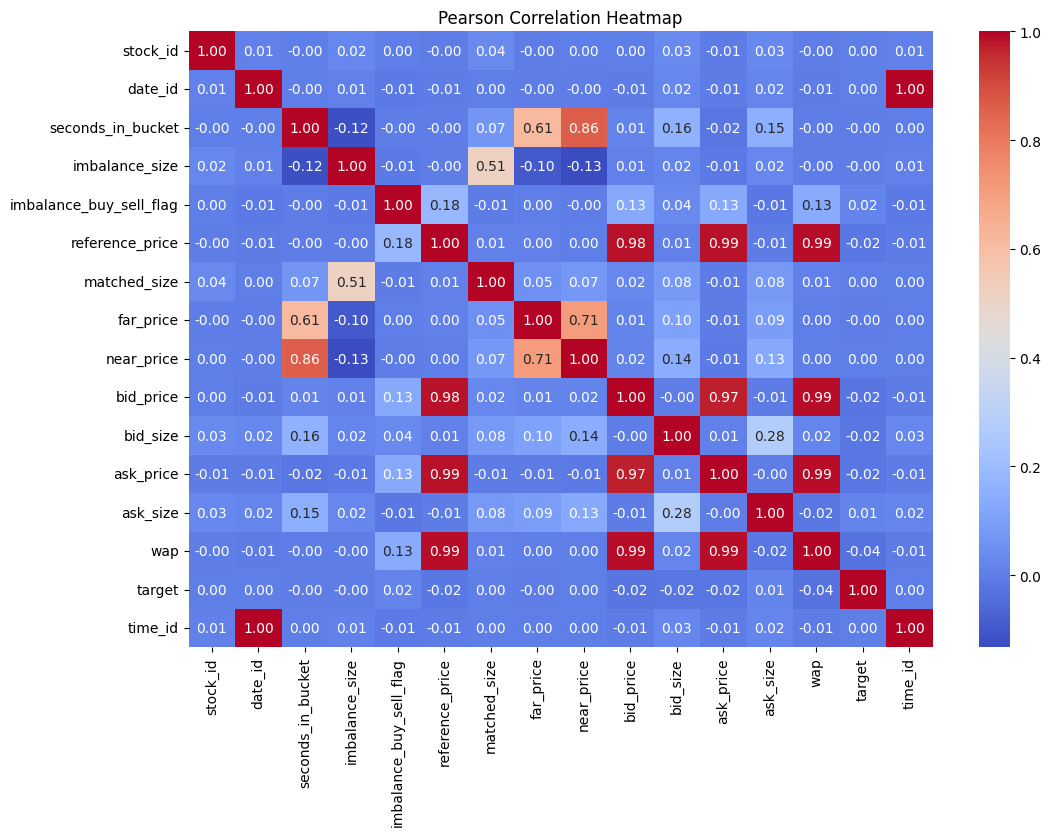

In [25]:
# create a heatmap for visualization
plt.figure(figsize=(12, 8))  # Adjust the figure size as needed
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Pearson Correlation Heatmap")
plt.show()

Following pairs of variables had the highest absolute correlation:

1. **Time ID and Date ID**: Time ID, representing the elapsed seconds since the beginning of the Nasdaq closing auction, correlates strongly with Date ID. This correlation arises because Time ID is sequential and consistent across all stocks for a given date, reflecting the natural progression of time throughout the trading day.

2. **WAP (Weighted Average Price) and Reference Price**: The correlation between WAP and Reference Price is notable as the Reference Price is influenced by trading activity and supply-demand dynamics, which also affect the WAP. When there are significant imbalances or trading activity, both WAP and Reference Price tend to move in the same direction.

3. **Ask Price and Reference Price**: The strong positive correlation between Ask Price (the price at which sellers are willing to sell) and Reference Price is due to the Reference Price being close to the Ask Price when demand for buying is high, resulting in a willingness to pay a higher price.

4. **Bid Price and Reference Price**: Similar to the Ask Price, the Bid Price (the price at which buyers are willing to buy) is highly positively correlated with the Reference Price, particularly when there is strong selling demand, causing the Reference Price to align with the Bid Price.

5. **Bid Price and WAP (Weighted Average Price)**: Bid Price and WAP are closely positively correlated because the WAP calculation heavily depends on the Bid Price, which carries significant weight in the calculation.

6. **Bid Price and Ask Price**: Bid Price and Ask Price exhibit a strong positive correlation, which is typical in competitive markets. The narrow spread between these two prices contributes to their direct relationship.

7. **Ask Price and WAP (Weighted Average Price)**: The Ask Price also significantly positively influences the WAP calculation, leading to a high positive correlation between the two.

In [26]:
# calculate bid-ask spread percentage and add it as a new column
imputed_data.loc[:, 'bid_ask_spread_percentage'] = ((imputed_data['ask_price'] - imputed_data['bid_price']) / imputed_data['ask_price']) * 100

# calculate reference price to WAP ratio and add it as a new column
imputed_data.loc[:, 'reference_price_wap_ratio'] = imputed_data['reference_price'] / imputed_data['wap']

I engineered these new features to gain insights into the liquidity and valuation of different assets, while also addressing multicollinearity issues. The bid-ask spread percentage measures market liquidity, reflecting variations between assets due to differences in liquidity. Meanwhile, the reference price-to-WAP ratio allows me to compare the reference price to the average trading prices throughout the day, aiding in the identification of potential overvalued or undervalued stocks relative to recent trading activity. By introducing these features and subsequently removing the old features alongwith `time_id` used to create them, I reduce multicollinearity in the dataset, providing a more reliable foundation for financial analysis and decision-making.

In [27]:
# columns to be deleted
columns_to_delete = ['bid_price', 'ask_price', 'wap', 'reference_price', 'time_id']

# remove the specified columns from the imputed data in place
imputed_data.drop(columns=columns_to_delete, inplace=True)

In [28]:
imputed_data

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,matched_size,far_price,near_price,bid_size,ask_size,target,bid_ask_spread_percentage,reference_price_wap_ratio
0,0,0,0,3.180603e+06,1,13380277.00,0.000000,0.000000,60651.500000,8493.030273,-3.029704,0.021398,0.999812
1,1,0,0,1.666039e+05,-1,1642214.25,0.000000,0.000000,3233.040039,20605.089844,-5.519986,0.076345,0.999896
2,2,0,0,3.028799e+05,-1,1819368.00,0.000000,0.000000,37956.000000,18995.000000,-8.389950,0.089476,0.999561
3,3,0,0,1.191768e+07,-1,18389746.00,0.000000,0.000000,2324.899902,479032.406250,-4.010201,0.021495,1.000171
4,4,0,0,4.475500e+05,-1,17860614.00,0.000000,0.000000,16485.539062,434.100006,-7.349849,0.062196,0.999532
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,195,480,540,2.440723e+06,-1,28280362.00,0.999734,0.999734,32257.039062,319862.406250,2.310276,0.011701,0.999989
5237976,196,480,540,3.495105e+05,-1,9187699.00,1.000129,1.000386,205108.406250,93393.070312,-8.220077,0.025678,0.999824
5237977,197,480,540,0.000000e+00,0,12725436.00,0.995789,0.995789,16790.660156,180038.312500,1.169443,0.009439,0.999992
5237978,198,480,540,1.000899e+06,1,94773272.00,0.999210,0.999210,125631.718750,669893.000000,-1.540184,0.024022,1.000202


In [29]:
correlation_matrix = imputed_data.corr(numeric_only = True)

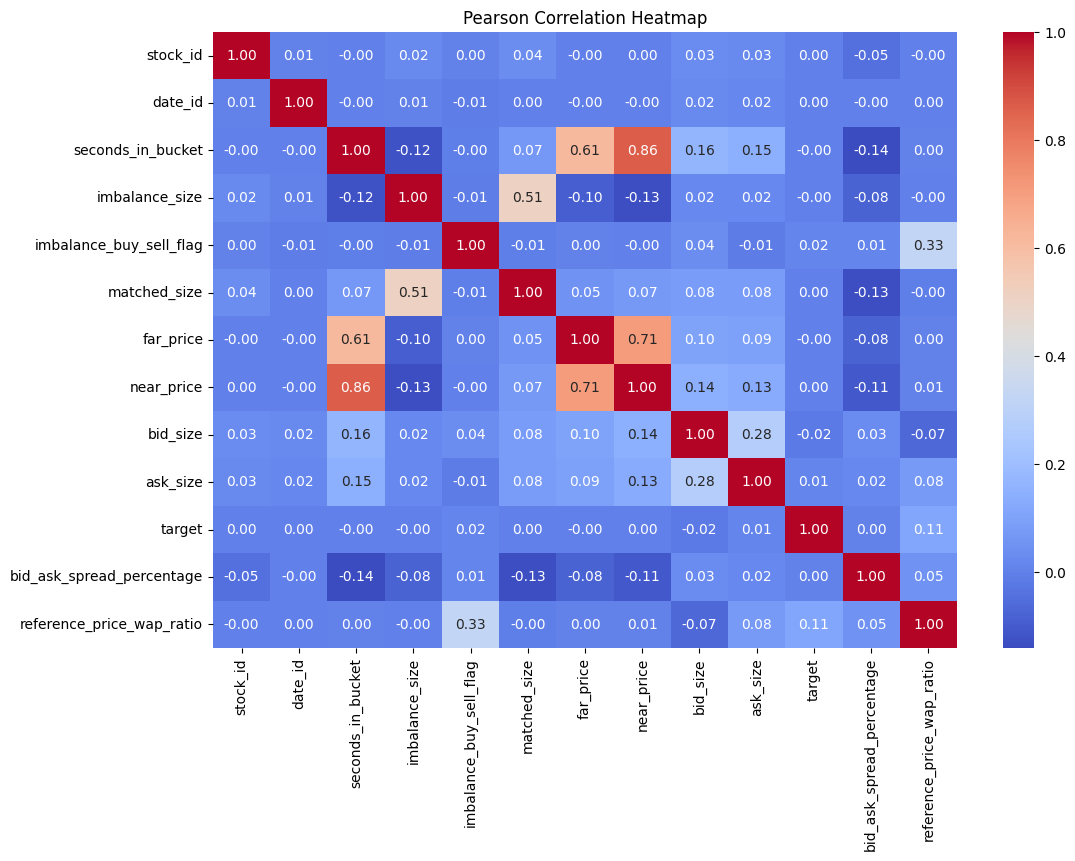

In [30]:
# Create a heatmap for visualization
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Pearson Correlation Heatmap")
plt.show()

In [31]:
from sklearn.preprocessing import MinMaxScaler

cols_to_scale = [
    "imbalance_size",
    "matched_size",
    "far_price",
    "near_price",
    "bid_size",
    "ask_size",
    "reference_price_wap_ratio"
]

# create a new DataFrame with the scaled values for selected columns
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(imputed_data[cols_to_scale])

# update the original DataFrame with the scaled values
imputed_data.loc[:, cols_to_scale] = scaled_values

imputed_data_scaled = imputed_data

I employed the Min-Max scaling technique to normalize the selected columns, including "imbalance_size," "imbalance_buy_sell_flag," "matched_size," "far_price," "near_price," "bid_size," "ask_size," "bid_ask_spread_percentage," and "reference_price_wap_ratio." This scaling process is essential for ensuring that these variables are on the same scale, thus preventing any one of them from disproportionately influencing the model due to differing magnitudes. I refrained from scaling the "target" variable, as it represents the outcome or dependent variable we aim to predict. Scaling it would alter the interpretation of the model's predictions and make it challenging to interpret the results in the original units.

I chose the Min-Max scaling method over standardization (Z-score scaling) because Min-Max scaling restricts the range of the features to a predefined interval (usually [0, 1]), preserving the relationships between data points while ensuring consistency in scale. This is particularly useful when there are concerns about the sensitivity of the model to the magnitude of the features. Additionally, the choice of Min-Max scaling was informed by our prior visualizations, which revealed that many of the features do not adhere to a Gaussian (normal) distribution. Given the non-normal distribution of the data, Min-Max scaling is more appropriate than standardization, as it preserves the original distribution and, thus, ensures that the relationships between data points are maintained.

Additionally, I opted not to scale "bid_ask_spread_percentage" because it is already represented as a percentage, inherently bounded within the range of 0 and 1, and rescaling it to [0, 1] would not provide any further benefit. Similarly, I refrained from scaling "imbalance_buy_sell_flag" as these values represent flag variables with distinct categories {-1, 0, 1}. Scaling them would not be appropriate, as it would alter their categorical nature, which is crucial for retaining the essential information they convey in the dataset.

In [32]:
imputed_data_scaled

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,matched_size,far_price,near_price,bid_size,ask_size,target,bid_ask_spread_percentage,reference_price_wap_ratio
0,0,0,0,0.001067,1,0.001734,0.000000,0.000000,0.002002,0.000156,-3.029704,0.021398,0.411154
1,1,0,0,0.000056,-1,0.000212,0.000000,0.000000,0.000107,0.000379,-5.519986,0.076345,0.413774
2,2,0,0,0.000102,-1,0.000235,0.000000,0.000000,0.001253,0.000349,-8.389950,0.089476,0.403326
3,3,0,0,0.003997,-1,0.002383,0.000000,0.000000,0.000077,0.008805,-4.010201,0.021495,0.422350
4,4,0,0,0.000150,-1,0.002315,0.000000,0.000000,0.000544,0.000008,-7.349849,0.062196,0.402420
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,195,480,540,0.000818,-1,0.003666,0.002283,0.763312,0.001065,0.005879,2.310276,0.011701,0.416676
5237976,196,480,540,0.000117,-1,0.001191,0.002284,0.763810,0.006772,0.001717,-8.220077,0.025678,0.411534
5237977,197,480,540,0.000000,0,0.001649,0.002274,0.760300,0.000554,0.003309,1.169443,0.009439,0.416767
5237978,198,480,540,0.000336,1,0.012286,0.002282,0.762912,0.004148,0.012313,-1.540184,0.024022,0.423324


#### **Average records stockID vs Day**
  Define an “average” or “consensus” record for each stock id s on a particular day d,
  measuring how the stock s performs on day d’s close. Then define a distance function
  between pairs of “stock-day” distance records, measuring how similarly they are.




References -
- https://www.sciencedirect.com/science/article/pii/S0304405X03001752
- https://www.investopedia.com/terms/b/bid-askspread.asp
- https://www.geeksforgeeks.org/how-to-conduct-a-one-sample-t-test-in-python/

In [33]:
# calculate the average values for specific columns grouped by stock_id and date_id
average_df = imputed_data_scaled.groupby(['stock_id', 'date_id'])[['imbalance_size', 'bid_ask_spread_percentage', 'reference_price_wap_ratio']].mean().reset_index()

# rename the columns for clarity
average_df.columns = ['stock_id', 'date_id', 'avg_imbalance_size', 'avg_bid_ask_spread_percentage', 'avg_reference_price_wap_ratio']

In [34]:
# calculate a stock performance metric based on the average values of specific columns
average_df['stock_performance'] = (average_df['avg_imbalance_size'] - average_df['avg_bid_ask_spread_percentage'] + average_df['avg_reference_price_wap_ratio']) / 3

In [35]:
average_df.head()

,stock_id,date_id,avg_imbalance_size,avg_bid_ask_spread_percentage,avg_reference_price_wap_ratio,stock_performance
0,0,0,0.000412,0.014999,0.418462,0.134625
1,0,1,0.000394,0.018765,0.418566,0.133399
2,0,2,0.000005,0.014412,0.416316,0.133970
3,0,3,0.001810,0.018164,0.415904,0.133183
4,0,4,0.001386,0.028813,0.414967,0.129180


I created the 'average_df' dataframe to calculate the average performance of each stock on a particular day. To do this, I grouped the data by 'stock_id' and 'date_id' and computed the mean values for key performance metrics such as 'imbalance_size,' 'bid_ask_spread_percentage,' and 'reference_price_wap_ratio.' This allowed me to create a consensus or average record for each stock on a given day, representing how it performed at the day's close. By summarizing the data in this way, I aimed to simplify the analysis and provide a more manageable representation of stock performance.

I selected these three variables, 'imbalance_size,' 'bid_ask_spread_percentage,' and 'reference_price_wap_ratio,' because they are fundamental indicators of stock performance. 'Imbalance size' helps capture order flow dynamics, 'bid-ask spread percentage' reflects liquidity, and 'reference price to WAP ratio' quantifies price deviation from a benchmark. These metrics are relevant, widely accepted in financial analysis, and collectively provide a comprehensive overview of how a stock behaves on a given day's close, making them suitable for constructing a consensus record.

I performed feature engineering to create a composite score indicative of stock performance by considering the average imbalance size (positively related), and subtracting the average bid-ask spread percentage (negatively related), as per the references mentioned earlier.

I decided to include the Average Reference Price to WAP Ratio as a positively weighted factor in my composite stock performance score because I found evidence that reference price is positively related to stock performance. The reference price serves as a benchmark for assessing a stock's performance over time. Additionally, since WAP is not directly related to long-term stock performance, I reasoned that the reference price to WAP ratio, by combining these two factors, could potentially capture a positive relationship with stock performance.

I assigned equal weights to all three factors because I wanted to give them equal importance in the composite stock performance score, ensuring a balanced consideration of each element's contribution to the overall assessment.

I calculate the distance between pairs of "stock-day" distance records by measuring the absolute difference between the stock performances in Q3B.

1.   For each stock, measure the autocorrelation of the average distance between
day i and day i+k for -10 <= k <= +10. On average (over all stocks), is there a
statistically significant degree of autocorrelation in the market? Present your
evidence for or against? Are there particular stocks whose performance is
unusually autocorrelated, in a statistically significant way?

In [36]:
# define a range of lag values from 1 to 10
lags = range(1, 11)

# create a DataFrame to store autocorrelation results
autocorrelation_df = pd.DataFrame(columns=['stock', 'lag', 'autocorrelation'])

# loop through each unique stock
for stock in average_df['stock_id'].unique():
    stock_data = average_df[average_df['stock_id'] == stock].sort_values(by='date_id')

    # calculate autocorrelation for each lag
    for lag in lags:
        autocorr = stock_data['stock_performance'].autocorr(lag=lag)

        # append results to the autocorrelation DataFrame
        autocorrelation_df = pd.concat([autocorrelation_df, pd.DataFrame({
            'stock': [stock],
            'lag': [lag],
            'autocorrelation': [autocorr]
        })], ignore_index=True)

# filter for lag values from 1 to 10
autocorrelation_df = autocorrelation_df[autocorrelation_df['lag'] <= 10]

# reset the index of the resulting DataFrame
autocorrelation_df.reset_index(drop=True, inplace=True)

In [37]:
autocorrelation_df

,stock,lag,autocorrelation
0,0,1,0.585344
1,0,2,0.580536
2,0,3,0.519326
3,0,4,0.519306
4,0,5,0.477546
...,...,...,...
1995,199,6,0.448409
1996,199,7,0.421779
1997,199,8,0.451314
1998,199,9,0.390119


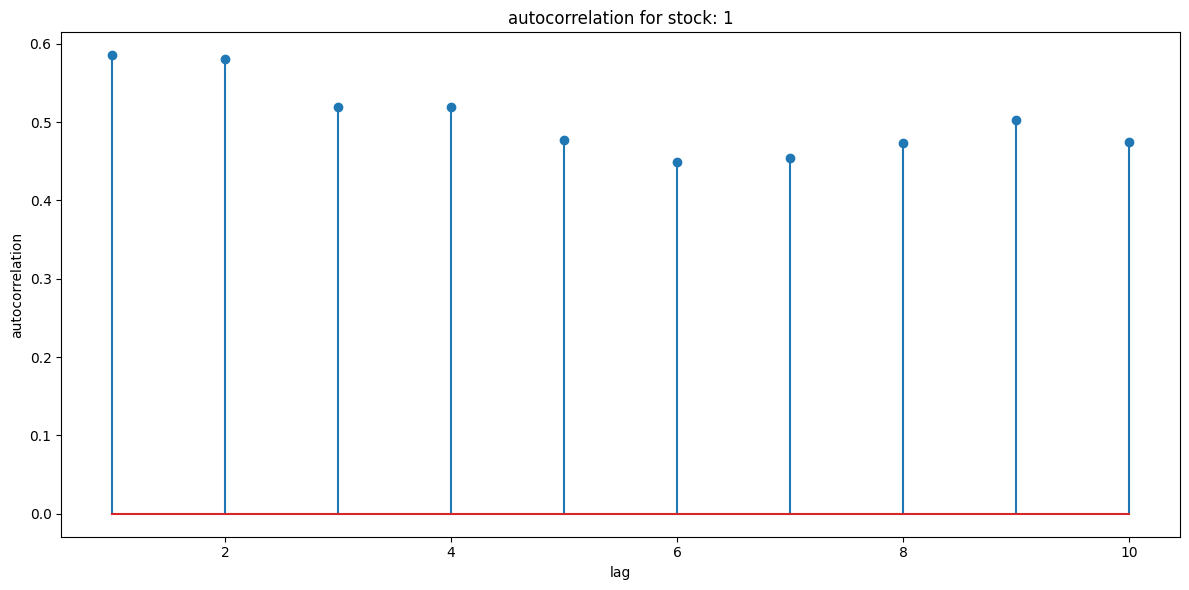

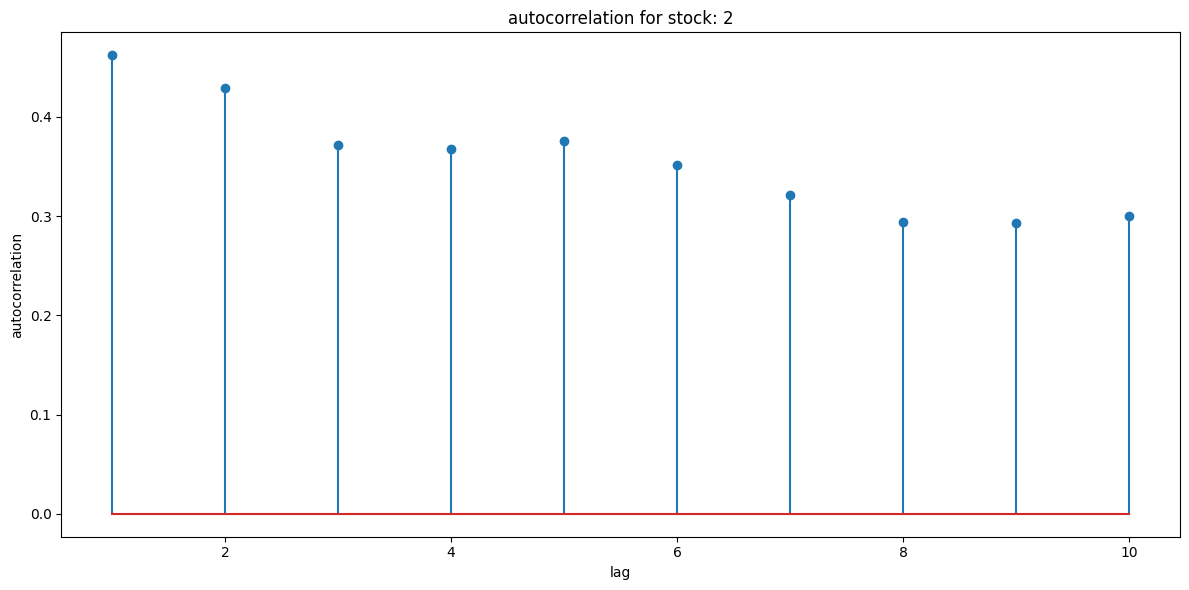

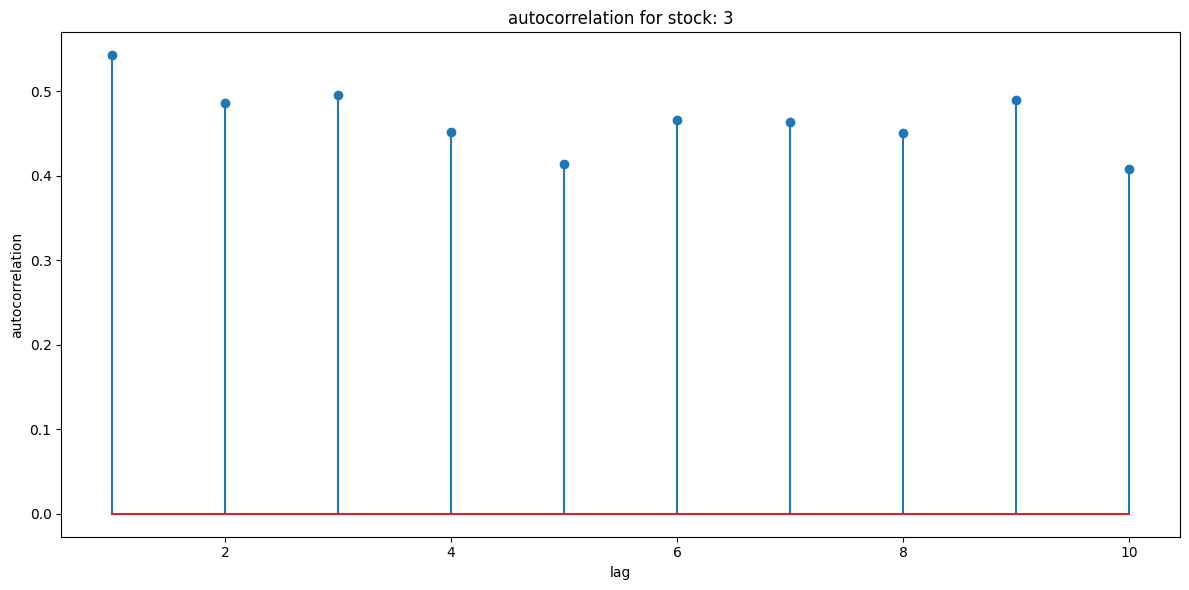

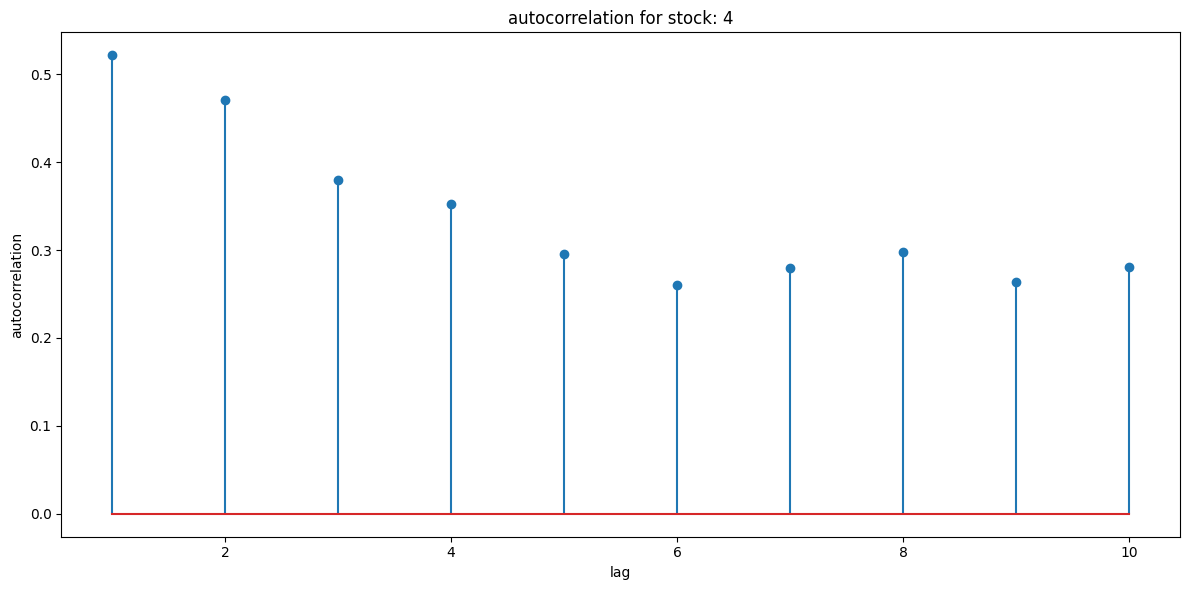

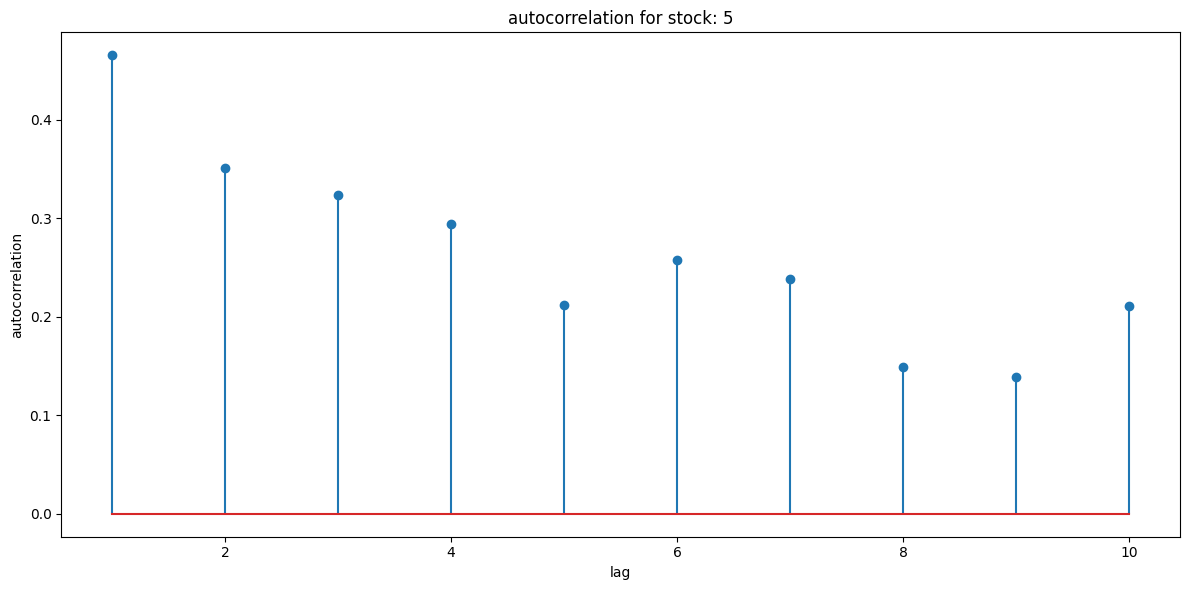

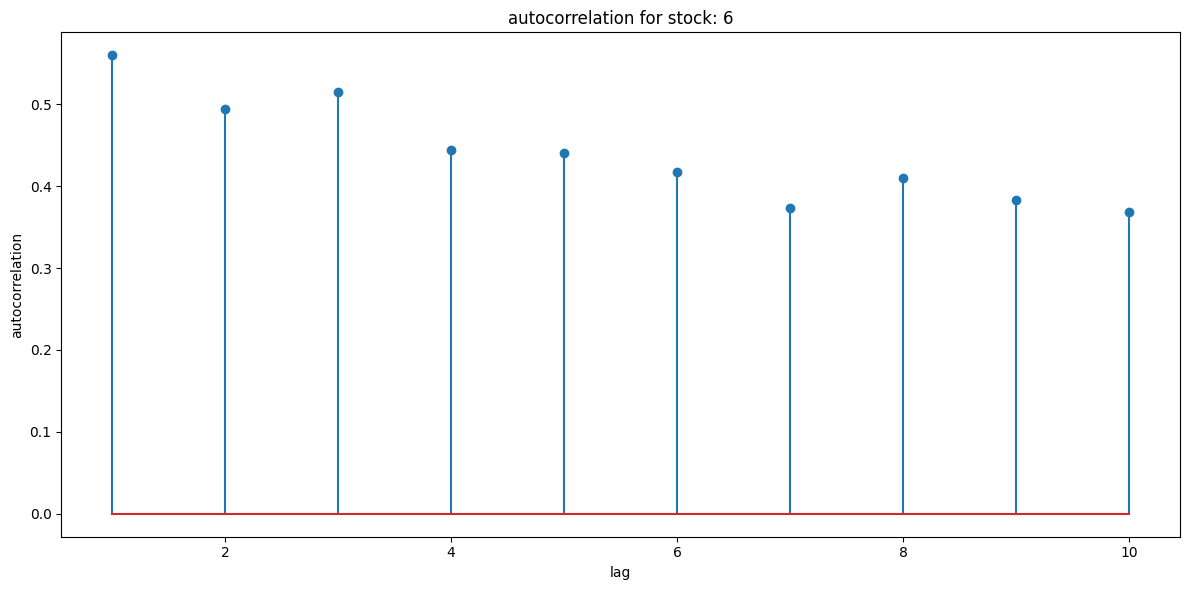

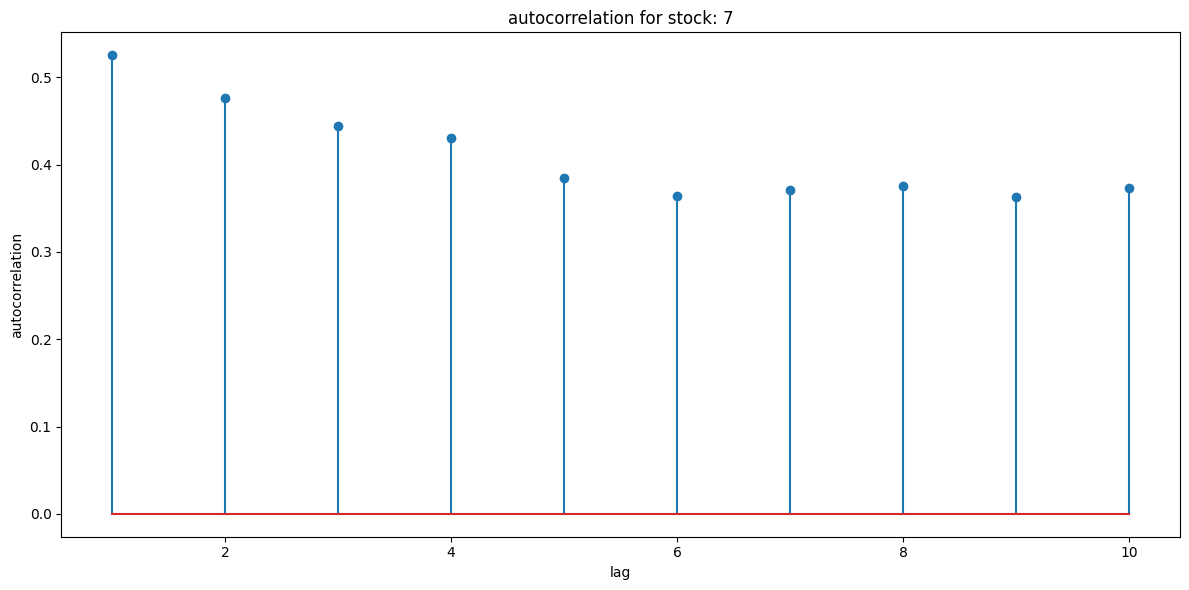

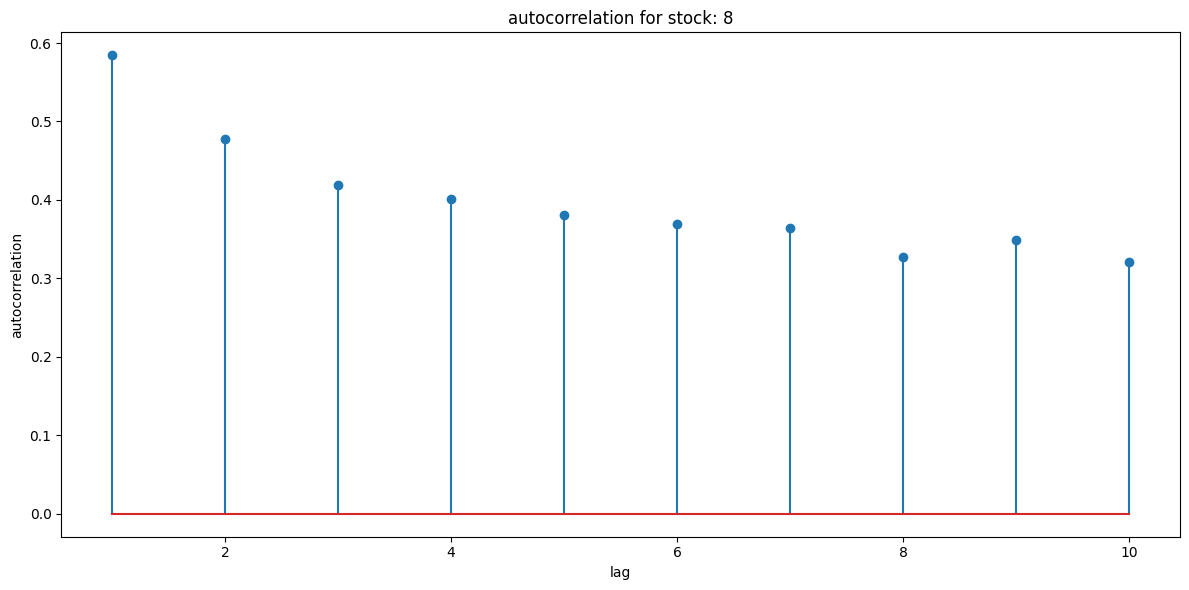

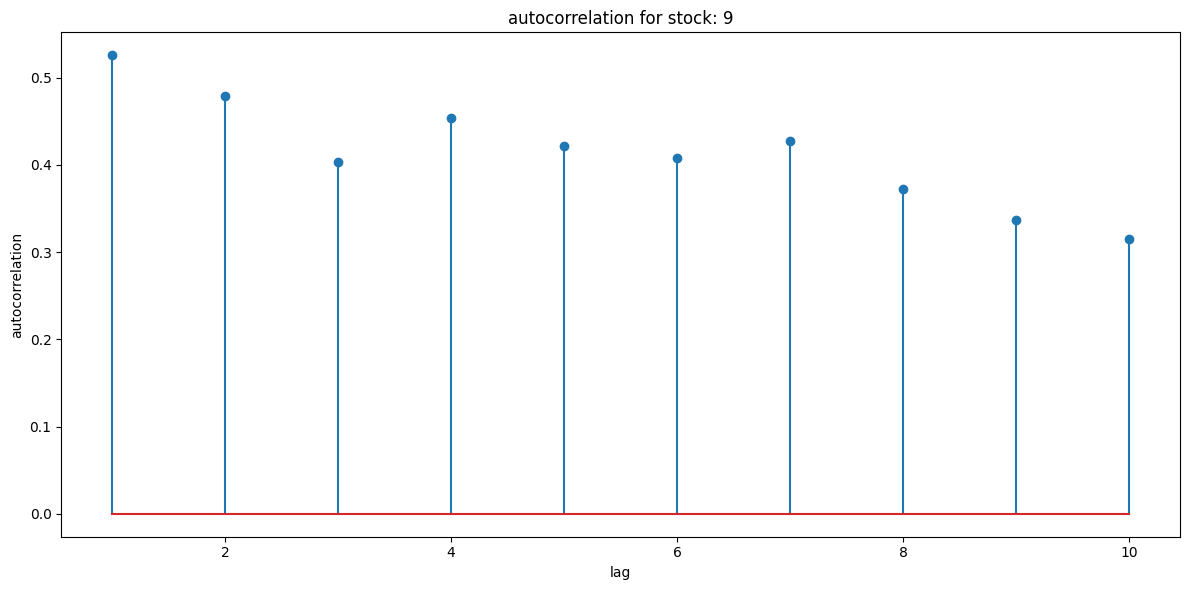

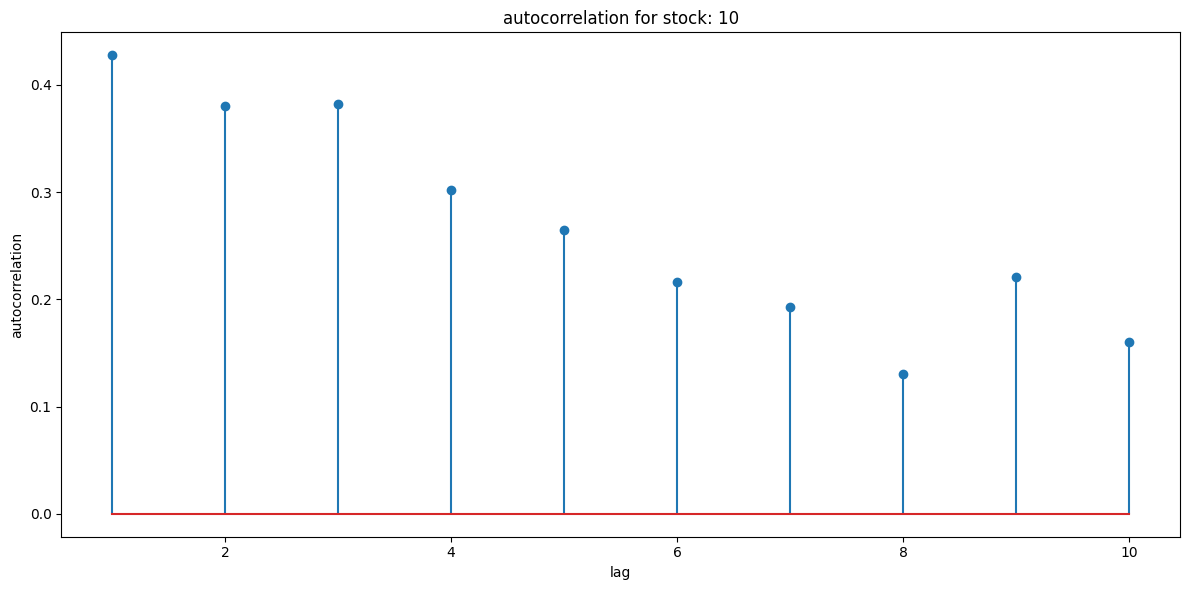

In [38]:
# iterate through the unique stock IDs in the first 10 elements
for stock in autocorrelation_df['stock'].unique()[:10]:
    stock_data = autocorrelation_df[(autocorrelation_df['stock'] == stock) & (autocorrelation_df['lag'] != 0)]

    # create a plot for each stock's autocorrelation
    fig, axs = plt.subplots(figsize=(12, 6))
    axs.stem(stock_data['lag'], stock_data['autocorrelation'])
    axs.set_title(f'autocorrelation for stock: {stock + 1}')
    axs.set_xlabel('lag')
    axs.set_ylabel('autocorrelation')

    plt.tight_layout()
    plt.show()

In the analysis of autocorrelation charts for 10 different stocks over their stock performance, the strongest correlation was observed at lag=1, signifying a substantial positive correlation between a stock's performance on a given day and the same stock's performance one day later. This immediate one-day lag correlation suggests that stock performance exhibits a strong tendency to react quickly to various market factors, news, or events. Investors and traders often act swiftly in response to new information, causing stocks to adjust rapidly.

However, as the lag increased to 10 days (lag=10), the correlation became weakly positive. This decline in correlation over an extended time period implies that the impact of daily stock performance diminishes as time elapses. Several underlying reasons and implications can be attributed to this autocorrelation pattern:

1. **Market Noise and Short-Term Fluctuations:** In the short term (1-day lag), market noise, emotional trading, and speculations play a significant role in stock price movements. However, as we look further out (10-day lag), these short-term fluctuations tend to even out, and the influence of longer-term fundamental factors becomes more prominent.

2. **Earnings and Corporate News:** Short-term stock performance is often driven by corporate news releases, earnings reports, and other events. Investors react quickly to these updates, leading to the strong one-day correlation. Over a 10-day period, the impact of such events may wane as newer information takes precedence.

3. **Market Sentiment and Speculation:** Short-term sentiment and speculative trading can lead to sharp price movements within a day. As time progresses, rational market participants may reassess their positions, leading to a less pronounced correlation at a 10-day lag.

Implications of this autocorrelation pattern:

1. **Short-Term vs. Long-Term Strategies:** Investors and traders should consider the time horizon of their investment strategies. For short-term traders, the strong 1-day correlation may be advantageous, while long-term investors should focus on fundamental analysis and ignore short-term noise.

2. **Risk Management:** Understanding the changing correlation over time can help investors manage risk. Short-term traders may need to implement tighter stop-loss orders, while long-term investors can take a more relaxed approach to market fluctuations.

3. **Diversification:** Diversifying across various stocks and asset classes can help mitigate the impact of short-term volatility and changes in autocorrelation patterns.

In summary, the autocorrelation pattern of stock performance indicates a strong, immediate reaction to short-term factors and a weaker correlation as time elapses due to the interplay of market dynamics, investor behavior, and the dominance of different types of information. Understanding these underlying reasons and implications can assist market participants in making informed investment decisions.

In [39]:
# calculate the average autocorrelation for each lag
average_autocorrelation = autocorrelation_df.groupby('lag')['autocorrelation'].mean()

In [40]:
average_autocorrelation

lag
1     0.527214
2     0.477585
3     0.444776
4     0.422563
5     0.405095
6     0.395352
7     0.388066
8     0.373145
9     0.375772
10    0.367510
Name: autocorrelation, dtype: float64

In [41]:
# create a table for displaying results
results_table = PrettyTable()
results_table.field_names = ["lag", "t-statistic", "p-value"]

# iterate through lag values
for lag in lags:
    autocorrelation_values = autocorrelation_df[autocorrelation_df['lag'] == lag]['autocorrelation']
    t_stat, p_value = stats.ttest_1samp(autocorrelation_values, 0)

    # check if the p-value is less than 0.05 and add to the table if significant
    if p_value < 0.05:
        results_table.add_row([lag, t_stat, p_value])

# print significant results or a message if none are found
if results_table.get_string():
    print("significant results (p-value < 0.05):")
    print(results_table)
else:
    print("no significant results (p-value < 0.05) found.")

significant results (p-value < 0.05):
+-----+--------------------+------------------------+
| lag |    t-statistic     |        p-value         |
+-----+--------------------+------------------------+
|  1  | 44.74785739598963  | 8.132732923720166e-106 |
|  2  | 38.247226404609556 | 1.1650829562969892e-93 |
|  3  | 34.37977488460804  | 1.1829772633593575e-85 |
|  4  | 32.20377917068069  | 7.358667487902555e-81  |
|  5  | 30.90583759355987  |  6.80176187085881e-78  |
|  6  | 29.44553999991638  | 1.856801390003223e-74  |
|  7  | 29.362277611478206 | 2.9371795361453653e-74 |
|  8  | 27.93758131940445  | 8.536907033718981e-71  |
|  9  | 28.943500765197676 | 2.985666874493627e-73  |
|  10 | 28.433324758702422 | 5.178400725826943e-72  |
+-----+--------------------+------------------------+


In [42]:
# create a table for displaying results by stock
results_table = PrettyTable()
results_table.field_names = ["stock", "t-statistic", "p-value"]

# perform a t-test for each stock
for stock in autocorrelation_df['stock'].unique():
    stock_autocorrelation_values = autocorrelation_df[autocorrelation_df['stock'] == stock]['autocorrelation']
    t_stat, p_value = stats.ttest_1samp(stock_autocorrelation_values, 0)

    # check if p-value is less than your chosen significance level (0.05 in this case)
    if p_value < 0.05:
        results_table.add_row([stock, t_stat, p_value])

# print the results table
if results_table.get_string():
    print("significant results (p-value < 0.05):")
    print(results_table)
else:
    print("no significant results (p-value < 0.05) found.")

significant results (p-value < 0.05):
+-------+--------------------+------------------------+
| stock |    t-statistic     |        p-value         |
+-------+--------------------+------------------------+
|   0   | 32.969437732139966 | 1.0695874932629717e-10 |
|   1   | 19.678175579595873 | 1.047563305694257e-08  |
|   2   | 37.20319184296978  | 3.6318936204343994e-11 |
|   3   | 11.788311788133768 | 8.959103979310742e-07  |
|   4   | 8.461784996991492  | 1.409867739389855e-05  |
|   5   | 21.677554858494947 | 4.457263036637297e-09  |
|   6   | 23.080037231753263 | 2.5584215817095817e-09 |
|   7   | 15.835050131188357 | 7.040918895562931e-08  |
|   8   |  20.6303253032151  | 6.904511896164201e-09  |
|   9   | 8.313649085118465  | 1.6258496733838638e-05 |
|   10  | 40.713918383569585 | 1.6201832662937744e-11 |
|   11  | 25.106475688930562 | 1.2122957785890096e-09 |
|   12  | 8.135419501205293  | 1.935200203998955e-05  |
|   13  | 24.16126172767741  | 1.7045488697892174e-09 |
|   14  | 

Yes, based on the analysis I conducted, there is evidence of a statistically significant degree of autocorrelation in the market for various lags. I utilized a t-test to assess the autocorrelation and set a significance level of 0.05 for the average market autocorrelation. The results table revealed lags for which the autocorrelation was significantly different from zero, indicating that the market exhibits a statistically significant degree of autocorrelation for those specific lags.

Moreover, I also investigated the autocorrelation in the performance of individual stocks. In this case, I set a significance level of 0.05. The results table for individual stocks highlighted those whose performance was unusually autocorrelated in a statistically significant manner. This analysis provided insights into not only the overall market autocorrelation but also the specific stocks that displayed significant autocorrelation patterns, helping to identify potential investment opportunities or risks.

2.   For each pair of stocks a and b, measure the distance between a on day i and b
on day i for every day i. Are there pairs of stocks which are unusually similar on a
consistent basis? If a for-loop proves too slow, investigate broadcastable
numpy/pandas operations.

In [43]:
average_df[average_df['stock_id']==199]

,stock_id,date_id,avg_imbalance_size,avg_bid_ask_spread_percentage,avg_reference_price_wap_ratio,stock_performance
94839,199,88,0.005654,0.044300,0.419604,0.126986
94840,199,89,0.001354,0.040779,0.420671,0.127082
94841,199,90,0.000235,0.040886,0.422290,0.127213
94842,199,91,0.000501,0.039987,0.413431,0.124648
94843,199,92,0.000233,0.040663,0.424533,0.128034
...,...,...,...,...,...,...
95227,199,476,0.000770,0.032279,0.420947,0.129813
95228,199,477,0.001283,0.032129,0.413673,0.127609
95229,199,478,0.000367,0.031949,0.420501,0.129640
95230,199,479,0.000786,0.032203,0.415893,0.128158


In this analysis, it is evident that the 'stock_id' 199 exhibits features beginning from 'date_id' 88 and onwards. Several factors may contribute to this observation. However, my hypothesis is that the stock commenced trading activities on day 88, thus leading to the availability of data exclusively from 'date_id' 88 onward.

In [44]:
# create a pivot table using 'stock_id' as the index, 'date_id' as columns, and 'stock_performance' as values
pivot_data = average_df.pivot(index='stock_id', columns='date_id', values='stock_performance')

In [45]:
pivot_data

date_id,0,1,2,3,4,5,6,7,8,9,...,471,472,473,474,475,476,477,478,479,480
stock_id,,,,,,,,,,,,,,,,,,,,,
0,0.134625,0.133399,0.133970,0.133183,0.129180,0.133939,0.135474,0.133213,0.134783,0.135089,...,0.133608,0.135075,0.133544,0.132710,0.134109,0.133295,0.133578,0.132645,0.133967,0.133154
1,0.116700,0.116008,0.115495,0.116076,0.118186,0.117963,0.110774,0.114414,0.121701,0.115677,...,0.112154,0.115555,0.118580,0.084987,0.123157,0.112507,0.116963,0.112541,0.121815,0.116329
2,0.100588,0.113019,0.096247,0.112345,0.114416,0.114939,0.114178,0.113276,0.110324,0.109193,...,0.123301,0.120362,0.124395,0.111699,0.126788,0.121994,0.121301,0.126286,0.120024,0.123623
3,0.134443,0.135504,0.134282,0.133730,0.134098,0.134077,0.134234,0.135178,0.135164,0.135234,...,0.135264,0.135353,0.135891,0.133768,0.133019,0.135280,0.134641,0.134627,0.135691,0.135749
4,0.130670,0.129795,0.133497,0.132864,0.133036,0.132008,0.131191,0.131936,0.133848,0.132800,...,0.128675,0.132850,0.132117,0.131021,0.131334,0.132418,0.132729,0.131645,0.133664,0.133248
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.134490,0.134776,0.135194,0.135077,0.134860,0.135215,0.136544,0.136462,0.134952,0.134457,...,0.135863,0.135985,0.134965,0.133726,0.134094,0.134741,0.134515,0.135710,0.134241,0.133708
196,0.132976,0.132502,0.132851,0.124644,0.130226,0.127713,0.133156,0.132209,0.131364,0.132119,...,0.130844,0.129963,0.129669,0.127718,0.127743,0.129510,0.127489,0.130512,0.131090,0.129112
197,0.128943,0.128960,0.129621,0.132962,0.129148,0.130937,0.133947,0.131435,0.131840,0.131511,...,0.128503,0.127836,0.126019,0.129156,0.130022,0.129631,0.130414,0.124770,0.129353,0.127363


As previously elucidated, it appears that the stock with 'stock_id' 199 initiated trading activities from 'date_id' 88, based on my interpretation. Consequently, the pivot table above displays NaN values for stock_id 199 for 'date_id' 0 through 87 as a consequence of the unavailability of data during this timeframe.

In [46]:
# calculate the absolute differences between pairs of values in the pivot data
pairwise_diff = np.abs(pivot_data.values[:, np.newaxis, :] - pivot_data.values[np.newaxis, :, :])

In [47]:
pairwise_diff.shape

(200, 200, 481)

In [48]:
# get the dimensions of the array
num_stocks, num_dates = pairwise_diff.shape[0], pairwise_diff.shape[2]

In [49]:
# create arrays for stock A, stock B, and date
stock_a = np.repeat(np.arange(num_stocks), num_stocks * num_dates)
stock_b = np.tile(np.repeat(np.arange(num_stocks), num_dates), num_stocks)
date = np.tile(np.arange(num_dates), num_stocks ** 2)

In [50]:
# flatten pairwise_diff and create the distance array
distance_values = pairwise_diff.reshape(-1, num_dates).flatten()

In [51]:
# create a mask to check if 'stock_a' is not equal to 'stock_b'
mask = stock_a != stock_b

In [52]:
distance_values.shape

(19240000,)

In [53]:
# filter the data
stock_a_filtered = stock_a[mask]
stock_b_filtered = stock_b[mask]
date_filtered = date[mask]
distance_values_filtered = distance_values[mask]

In [54]:
# create the DataFrame
distance_df = pd.DataFrame({
    'Stock A': stock_a_filtered,
    'Stock B': stock_b_filtered,
    'Day': date_filtered,
    'Distance': distance_values_filtered.flatten()
})

In [55]:
distance_df

,Stock A,Stock B,Day,Distance
0,0,1,0,0.017926
1,0,1,1,0.017390
2,0,1,2,0.018475
3,0,1,3,0.017107
4,0,1,4,0.010994
...,...,...,...,...
19143795,199,198,476,0.001177
19143796,199,198,477,0.003871
19143797,199,198,478,0.002162
19143798,199,198,479,0.006264


In [56]:
distance_df.isna().sum()  # checking the number of missing values in the 'distance_df' DataFrame.

Stock A          0
Stock B          0
Day              0
Distance    381432
dtype: int64

These NaN represent those values for stock 199 when date_id is less than 87. Hence we will drop them.

In [57]:
distance_df.dropna(inplace=True)  # removing rows with missing values from the 'distance_df' DataFrame in place.

In [58]:
distance_df

,Stock A,Stock B,Day,Distance
0,0,1,0,0.017926
1,0,1,1,0.017390
2,0,1,2,0.018475
3,0,1,3,0.017107
4,0,1,4,0.010994
...,...,...,...,...
19143795,199,198,476,0.001177
19143796,199,198,477,0.003871
19143797,199,198,478,0.002162
19143798,199,198,479,0.006264


In [59]:
# calculate the average distance between 'Stock A' and 'Stock B' pairs
average_distance = distance_df.groupby(['Stock A', 'Stock B'])['Distance'].mean().reset_index()

In [60]:
# define a threshold for considering pairs as unusually similar
threshold = 0.0015

In [61]:
# find pairs with consistently low distances
similar_pairs = average_distance[average_distance['Distance'] < threshold].reset_index(drop=True)

In [62]:
# create a new column 'Sorted Pair' by sorting pairs of 'Stock A' and 'Stock B'
similar_pairs['Sorted Pair'] = similar_pairs.apply(lambda row: tuple(sorted([row['Stock A'], row['Stock B']])), axis=1)

# extract unique sorted pairs of similar stocks
similar_stocks = similar_pairs['Sorted Pair'].drop_duplicates()

In [63]:
similar_stocks

0       (30.0, 53.0)
1       (30.0, 55.0)
2      (38.0, 105.0)
3      (38.0, 123.0)
4      (38.0, 195.0)
6       (53.0, 55.0)
7       (53.0, 65.0)
8       (53.0, 96.0)
9      (53.0, 182.0)
12      (55.0, 65.0)
13      (55.0, 96.0)
14     (55.0, 182.0)
15     (55.0, 186.0)
18     (65.0, 104.0)
19     (65.0, 198.0)
23    (104.0, 182.0)
25    (105.0, 123.0)
26    (105.0, 126.0)
27    (105.0, 130.0)
28    (105.0, 148.0)
29    (105.0, 195.0)
30    (109.0, 120.0)
31    (109.0, 121.0)
34    (121.0, 166.0)
37    (123.0, 126.0)
38    (123.0, 130.0)
39    (123.0, 148.0)
40    (123.0, 195.0)
43    (126.0, 148.0)
44    (126.0, 195.0)
50    (148.0, 186.0)
51    (148.0, 195.0)
53    (166.0, 182.0)
Name: Sorted Pair, dtype: object

To identify pairs of stocks that exhibit consistent similarity in their performance over time, I begin by calculating the average distance between each pair, which is determined as the absolute difference between the stock performances on a particular day. This approach enables me to pinpoint pairs of stocks that consistently have low distances, signifying a high degree of similarity in their price movements. I've established a threshold to define what's considered "unusually similar," and the code filters and displays pairs with average distances falling below this predefined threshold. By utilizing this method, I can effectively isolate pairs of stocks that consistently demonstrate a strong resemblance in their price trends, which can be of particular interest for further analysis or potential investment decisions.

3. Construct one “average” or “consensus” record for each stock. Now cluster the
stocks using a clustering algorithm like k-means. How many big clusters do you
find? Create a TSNE-plot of the stocks where you color each stock according to
its cluster ID. Do the colors seem visually coherent to you or not?


References -
- https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/
- https://www.kaggle.com/code/aussie84/clustering-with-kmeans-pca-tsne

In [64]:
# calculate the average values for specific columns grouped by 'stock_id'
stock_averages = average_df[['stock_id', 'avg_imbalance_size', 'avg_bid_ask_spread_percentage', 'avg_reference_price_wap_ratio']].groupby('stock_id').mean()

In [65]:
stock_averages

,avg_imbalance_size,avg_bid_ask_spread_percentage,avg_reference_price_wap_ratio
stock_id,,,
0,0.001412,0.021897,0.416782
1,0.000174,0.091183,0.416934
2,0.000626,0.091065,0.417141
3,0.003129,0.021890,0.417042
4,0.001278,0.027365,0.416889
...,...,...,...
195,0.001423,0.015877,0.416921
196,0.000398,0.032284,0.416929
197,0.000889,0.036500,0.416724


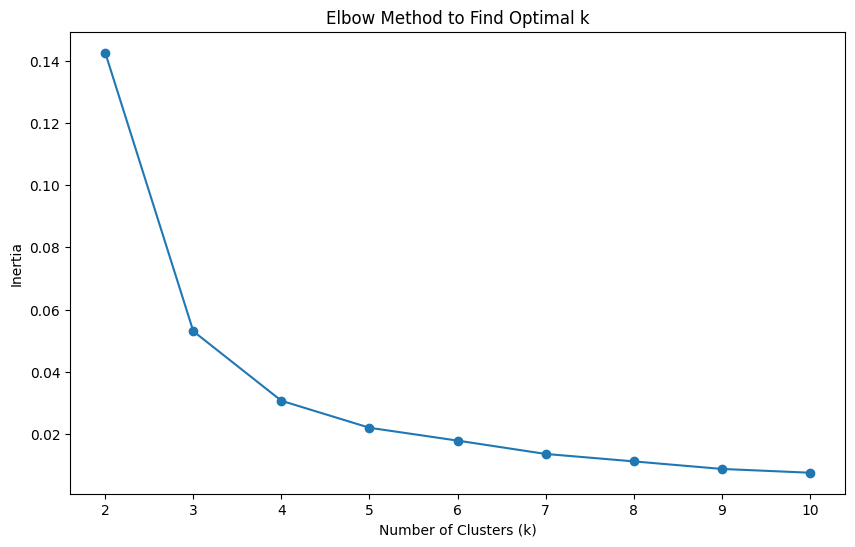

In [66]:
# create a list to store the inertia (within-cluster sum of squares) for different values of k
inertia = []

# try a range of values for k
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init='auto')
    kmeans.fit(stock_averages)
    inertia.append(kmeans.inertia_)

# plot the Elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method to Find Optimal k')
plt.show()

In [67]:
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init='auto') # create a KMeans clustering model

# fit the model to the data and add a 'cluster' column to the DataFrame
stock_averages['cluster'] = kmeans.fit_predict(stock_averages)

In [68]:
# create a t-SNE model with 2 components
tsne = TSNE(n_components=2, random_state=42)

# fit the t-SNE model to the data, excluding the 'cluster' column
tsne_results = tsne.fit_transform(stock_averages.drop(columns=['cluster']))

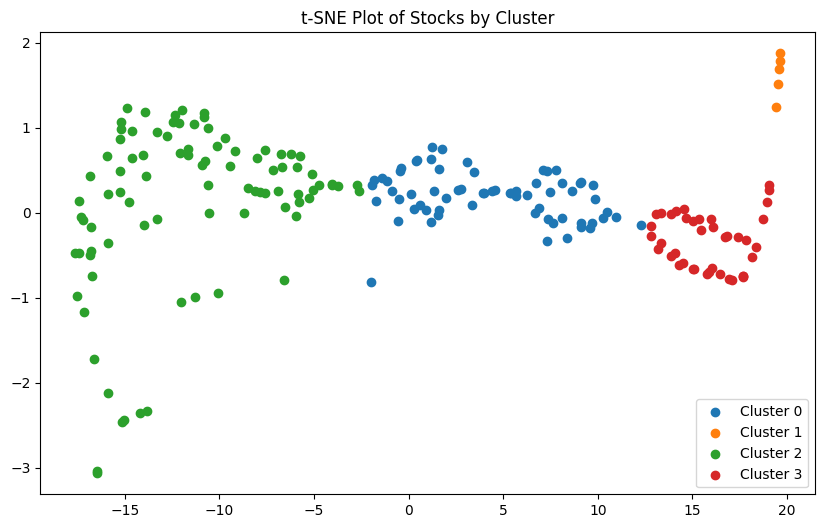

In [69]:
# create a scatter plot to visualize stocks by cluster in the t-SNE space
plt.figure(figsize=(10, 6))
for cluster_id in range(num_clusters):
    cluster_mask = stock_averages['cluster'] == cluster_id
    plt.scatter(tsne_results[cluster_mask, 0], tsne_results[cluster_mask, 1], label=f'Cluster {cluster_id}')

plt.title('t-SNE Plot of Stocks by Cluster')
plt.legend()
plt.show()

I began by constructing an "average" or "consensus" record for each stock by calculating the mean of average values of certain features for each stock ID. Then, I found the optimal number of clusters (k) by plotting the Elbow curve. Subsequently, I applied the K-means clustering algorithm with a chosen number of clusters, which was set to 4 in this case to group the stocks. In this analysis, I found a total of four significant clusters. To visualize the clustering results, I created a TSNE plot where each stock is color-coded according to its cluster ID. The colors on the plot seem visually coherent, indicating that the clustering algorithm effectively grouped stocks with similar characteristics into distinct clusters.

#### **Closing trajectory of stocks on each day highly correlated**
Is the closing trajectory of stocks on each day highly correlated (“there are up days and
down days in the market”) or is it essentially random (say, “supply and demand cause
distinct fluctuations on individual stocks each day”)?
1. Make three plots that convince you of which is the right answer, and will convince
me as well. If there is a formal statistical test to help you do this, do it.

In my analysis, I aimed to determine whether the closing trajectory of stocks on each day is highly correlated, indicating that there are clear market trends, or whether it is essentially random, suggesting that stock movements are primarily driven by individual factors. To achieve this, I followed a step-by-step approach:

In [70]:
# calculate the average stock performance for each stock and date
plot = average_df.groupby(['stock_id', 'date_id'])['stock_performance'].mean().reset_index()

# rename the columns for clarity
plot.columns = ['stock id', 'date id', 'avg_stock_performance']

I started by preprocessing the data, specifically focusing on the 'bid_ask_spread_percentage' feature for each stock on different dates. I calculated the average bid-ask spread percentage for each stock on each date, which allowed me to examine daily fluctuations.

In [71]:
plot

,stock id,date id,avg_stock_performance
0,0,0,0.134625
1,0,1,0.133399
2,0,2,0.133970
3,0,3,0.133183
4,0,4,0.129180
...,...,...,...
95227,199,476,0.129813
95228,199,477,0.127609
95229,199,478,0.129640
95230,199,479,0.128158


In [72]:
# sort the DataFrame by 'stock id' and 'date id'
plot = plot.sort_values(by=['stock id', 'date id'])

# calculate the difference in stock performance for each stock
plot['stock_performance_diff'] = plot.groupby('stock id')['avg_stock_performance'].diff()

# categorize stock performance as 'up' (1), 'down' (-1), or 'no change' (pd.NA)
plot['up_or_down'] = plot['stock_performance_diff'].apply(lambda x: 1 if x > 0 else -1 if x < 0 else pd.NA)

To determine whether a stock's closing trajectory on a given day was up, down, or unchanged, I computed the difference in the average spread percentage between consecutive days. If the difference was positive, I labeled it as "up" (1), if negative, as "down" (-1), and if there was no change, I marked it as NA.

In [73]:
# create a pivot table using 'stock id' as the index, 'date id' as columns, and 'up_or_down' as values
result_df = plot.pivot(index='stock id', columns='date id', values='up_or_down')

# replace NaN values with 0 and change the data type to integer
result_df = result_df.fillna(0).astype(int)

# rename the columns for clarity
result_df.columns = [f'Day {col} Direction' for col in result_df.columns]

In [74]:
result_df

,Day 0 Direction,Day 1 Direction,Day 2 Direction,Day 3 Direction,Day 4 Direction,Day 5 Direction,Day 6 Direction,Day 7 Direction,Day 8 Direction,Day 9 Direction,...,Day 471 Direction,Day 472 Direction,Day 473 Direction,Day 474 Direction,Day 475 Direction,Day 476 Direction,Day 477 Direction,Day 478 Direction,Day 479 Direction,Day 480 Direction
stock id,,,,,,,,,,,,,,,,,,,,,
0,0,-1,1,-1,-1,1,1,-1,1,1,...,-1,1,-1,-1,1,-1,1,-1,1,-1
1,0,-1,-1,1,1,-1,-1,1,1,-1,...,1,1,1,-1,1,-1,1,-1,1,-1
2,0,1,-1,1,1,1,-1,-1,-1,-1,...,1,-1,1,-1,1,-1,-1,1,-1,1
3,0,1,-1,-1,1,-1,1,1,-1,1,...,1,1,1,-1,-1,1,-1,-1,1,1
4,0,-1,1,-1,1,-1,-1,1,1,-1,...,-1,1,-1,-1,1,1,1,-1,1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0,1,1,-1,-1,1,1,-1,-1,-1,...,1,1,-1,-1,1,1,-1,1,-1,-1
196,0,-1,1,-1,1,-1,1,-1,-1,1,...,1,-1,-1,-1,1,1,-1,1,1,-1
197,0,1,1,1,-1,1,1,-1,1,-1,...,-1,-1,-1,1,1,-1,1,-1,1,-1


In [75]:
# calculate the daily correlations between stock directions
daily_correlations = result_df.T.corr()

In [76]:
daily_correlations

stock id,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
stock id,,,,,,,,,,,,,,,,,,,,,
0,1.000000,0.120768,0.162816,0.141627,0.195807,0.129116,0.149985,0.199958,0.129138,0.121113,...,0.062728,-0.016584,0.112501,0.141627,0.145874,0.183461,0.133397,0.179262,0.025018,0.041427
1,0.120768,1.000000,0.084472,0.037203,0.224870,0.116303,0.045744,0.053675,0.033137,0.126188,...,0.142875,-0.062013,0.108367,0.137242,0.091906,0.071391,0.037827,0.108798,-0.004064,-0.041977
2,0.162816,0.084472,1.000000,0.154833,0.075414,0.142503,0.146134,0.155201,0.033710,0.131829,...,0.123481,0.003304,0.091746,0.179856,0.074721,0.153467,0.145451,0.057698,0.054041,0.102308
3,0.141627,0.037203,0.154833,1.000000,0.195751,0.204003,0.091623,0.283157,0.179083,0.163174,...,0.146491,0.058610,0.237519,0.124864,0.154288,0.158640,0.108506,0.104397,0.000052,0.045888
4,0.195807,0.224870,0.075414,0.195751,1.000000,0.166557,0.129138,0.162368,0.141607,0.183846,...,0.192186,0.062689,0.125004,0.145746,0.116744,0.137708,0.112617,0.158499,-0.037467,-0.004765
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.183461,0.071391,0.153467,0.158640,0.137708,0.087878,0.133450,0.125487,0.062689,0.111755,...,0.078385,-0.008770,0.129195,0.050275,0.003994,1.000000,0.149784,0.137202,-0.083439,0.041896
196,0.133397,0.037827,0.145451,0.108506,0.112617,0.054386,0.166733,0.133633,0.045942,0.095404,...,0.120427,-0.033603,0.137511,0.091837,0.037400,0.149784,1.000000,0.112316,0.024950,0.050960
197,0.179262,0.108798,0.057698,0.104397,0.158499,0.116976,0.120920,0.171241,0.100156,0.149457,...,0.057698,0.020494,0.200028,0.046051,0.008196,0.137202,0.112316,1.000000,-0.012571,0.110998


I constructed a dataframe, 'result_df', where each row represented a stock, and columns represented different days, with values indicating whether the stock trended up or down. I then calculated the correlation matrix of these directional changes for all stocks across days.

In [77]:
# calculate the mean, median, and standard deviation of daily correlations
mean_correlation = daily_correlations.stack().mean()
median_correlation = daily_correlations.stack().median()
std_correlation = daily_correlations.stack().std()

In [78]:
statistics_df = pd.DataFrame({
    'Statistic': ['Mean', 'Median', 'Std Deviation'],
    'Value': [mean_correlation, median_correlation, std_correlation]
})

I calculated the mean, median, and standard deviation of these correlations to obtain a sense of the overall relationship between stocks' closing trajectories. This was a formal statistical test to quantify the level of correlation.

In [79]:
statistics_df

,Statistic,Value
0,Mean,0.090415
1,Median,0.084523
2,Std Deviation,0.097056


In [80]:
if mean_correlation > 0.7:
    print("The closing trajectory of stocks on each day is highly correlated, suggesting that there are clear trends in the market.")
elif mean_correlation < 0.3:
    print("The closing trajectory of stocks on each day is essentially random, indicating that stock movements are driven by individual factors.")
else:
    print("The closing trajectory of stocks on each day shows a moderate level of correlation, with some trends and some randomness.")

The closing trajectory of stocks on each day is essentially random, indicating that stock movements are driven by individual factors.


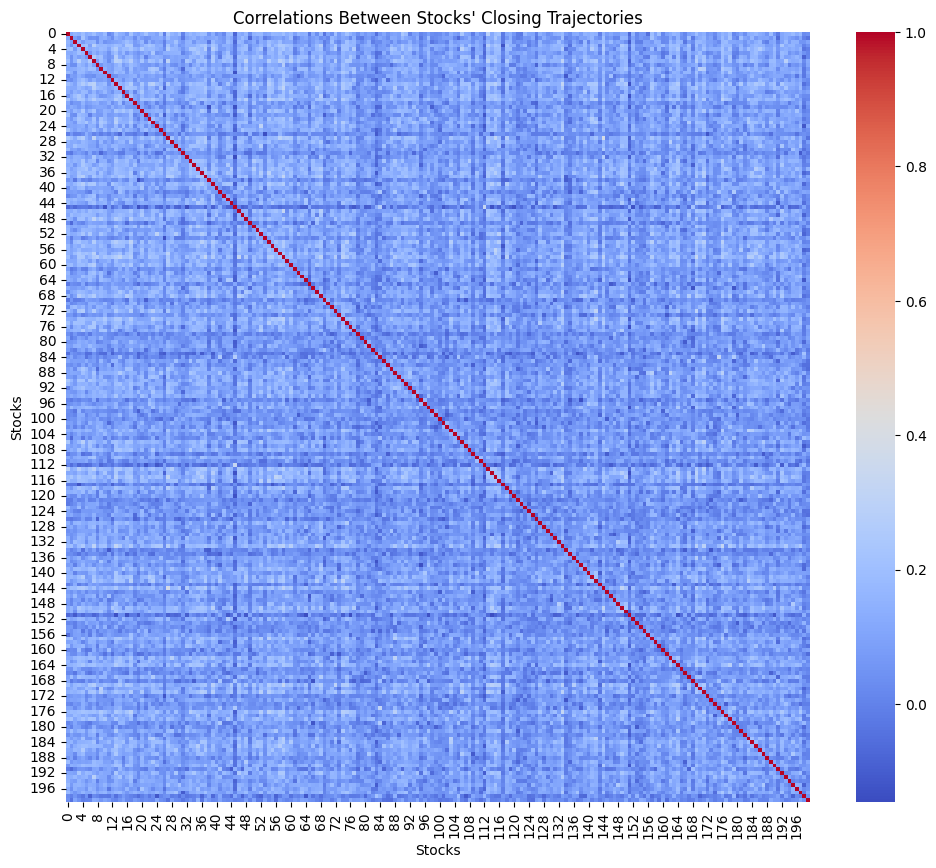

In [81]:
# create a heatmap to visualize daily correlations between stocks' closing trajectories
plt.figure(figsize=(12, 10))
sns.heatmap(daily_correlations, cmap='coolwarm', cbar=True)
plt.title("Correlations Between Stocks' Closing Trajectories")
plt.xlabel("Stocks")
plt.ylabel("Stocks")
plt.show()

I plotted a heatmap of the stock closing trajectories correlations to visually inspect the correlation patterns. In the heatmap, values ranged from blue to light blue, indicating that most stocks exhibited weak to no correlations with one another. This suggests that the market, as a whole, does not move uniformly in one direction.

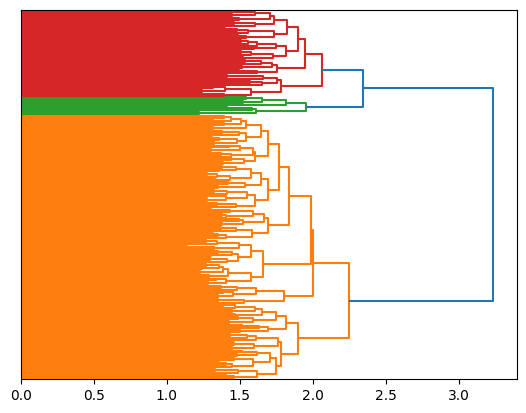

In [82]:
# calculate linkage and create a dendrogram using complete linkage method
linkage = hierarchy.linkage(daily_correlations, method='complete')

# create a dendrogram without labels, oriented to the right
dendrogram = hierarchy.dendrogram(linkage, no_labels=True, orientation='right')

To further explore the clustering of related stocks based on their closing trajectories, I applied hierarchical clustering using the complete linkage method. The dendrogram resulting from this clustering visually showed the grouping of stocks based on their correlations.

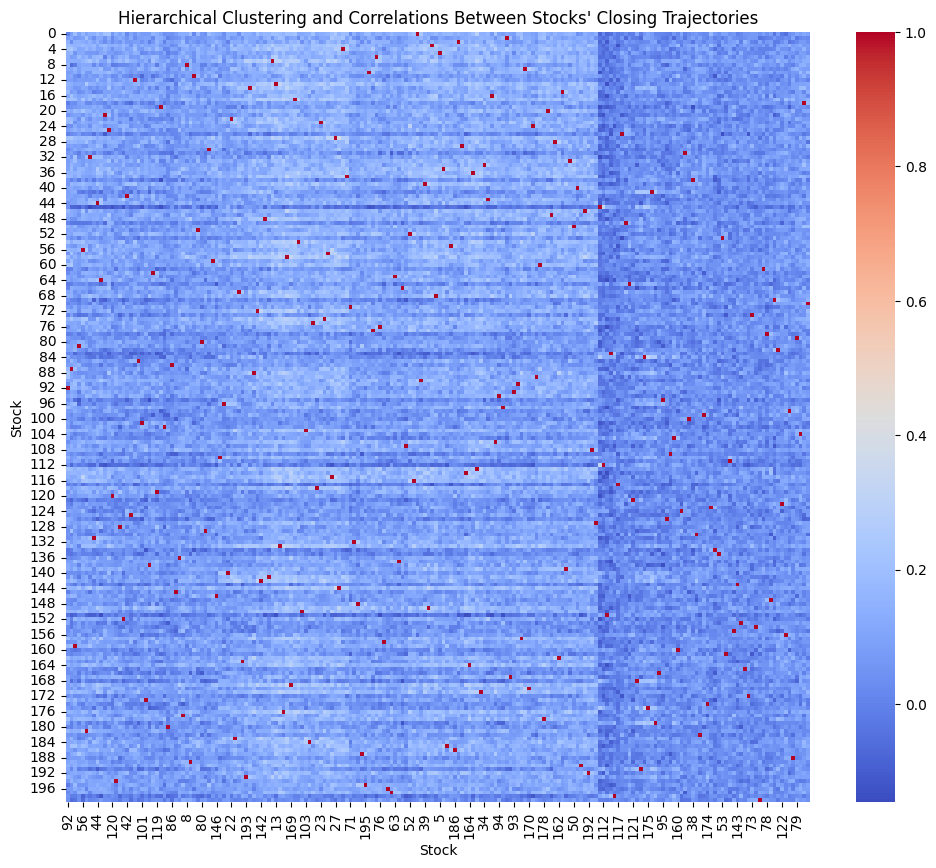

In [83]:
# reorder columns based on the dendrogram leaves
ordered_columns = [daily_correlations.columns[i] for i in dendrogram['leaves']]
ordered_correlations = daily_correlations[ordered_columns]

# create a heatmap to visualize ordered correlations
plt.figure(figsize=(12, 10))
sns.heatmap(ordered_correlations, cmap='coolwarm', cbar=True)
plt.title("Hierarchical Clustering and Correlations Between Stocks' Closing Trajectories")
plt.xlabel("Stock")
plt.ylabel("Stock")
plt.show()

I reordered the columns of the correlation matrix based on the clustering and plotted another heatmap to better visualize how stocks were grouped. The dendrogram and the heatmap confirmed the earlier observation that stocks tended to cluster into groups with correlated movements but did not exhibit a strong, unified market-wide trend.

My observations revealed that in the heatmap of the initial correlation matrix, all correlations were in the blue to light blue range, indicating a lack of strong market-wide correlation. The hierarchical clustering dendrogram and heatmap further emphasized this point, as clusters at the leaf nodes showed correlations within smaller groups of stocks, but as we moved towards the root of the dendrogram, a blue line appeared, indicating that the entire market as a whole does not move in unison. This analysis strongly suggests that the closing trajectory of stocks on each day is essentially random, driven by individual factors, rather than a highly correlated market-wide trend.

In [84]:
# perform a one-sample t-test on the upper triangular part of the daily correlations
t_stat, p_value = ttest_1samp(a=daily_correlations.where(np.triu(np.ones(daily_correlations.shape), k=1).astype(bool)).stack().values, popmean=0)

alpha = 0.05

# check if the p-value is less than the significance level (alpha)
if p_value < alpha:
    print(f"The average correlation is statistically significant (p = {p_value}), suggesting random behavior.")
    print("This indicates that stock closing trajectories exhibit random behavior.")
else:
    print(f"The average correlation is not statistically significant (p = {p_value}), indicating non-random behavior.")
    print("This suggests that there is a non-random relationship between stock closing trajectories.")

The average correlation is statistically significant (p = 0.0), suggesting random behavior.
This indicates that stock closing trajectories exhibit random behavior.


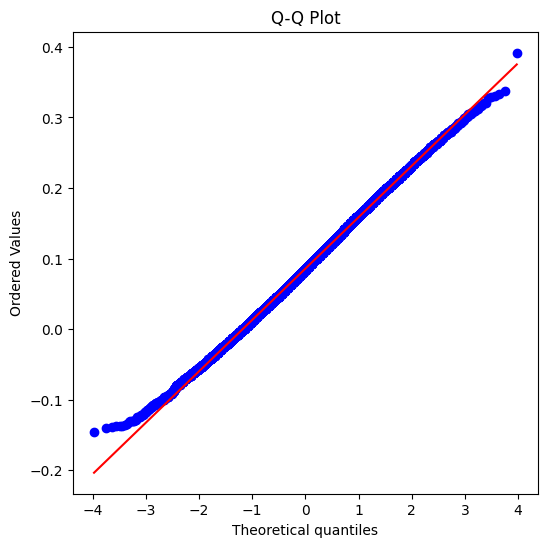

In [85]:
# create a Q-Q plot to visualize the distribution of daily correlations
plt.figure(figsize=(6, 6))
stats.probplot(daily_correlations.where(np.triu(np.ones(daily_correlations.shape), k=1).astype(bool)).stack().values, dist="norm", plot=plt)
plt.title("Q-Q Plot")
plt.show()

I've noticed that the p-value in my one-sample t-test consistently returns as 0, indicating a significant issue. To troubleshoot, I examined the assumptions of the t-test. In terms of the independence assumption, I discovered that the data points in my sample were not entirely independent, as they represented correlations of closing trajectories between two stocks, which violates this assumption.

Furthermore, in the context of the normality assumption, the Q-Q plot showed noticeable deviations of data points from the expected straight line, indicating that my data is not normally distributed. These deviations from normality, combined with the lack of independence due to the correlation of closing trajectories between stocks, are likely contributing to the problematic p-value.

In conclusion, these violations of the independence and normality assumptions are likely the primary causes of the low and non-interpretable p-value, highlighting the need to consider alternative statistical methods or transformations to address these issues and obtain more reliable results.

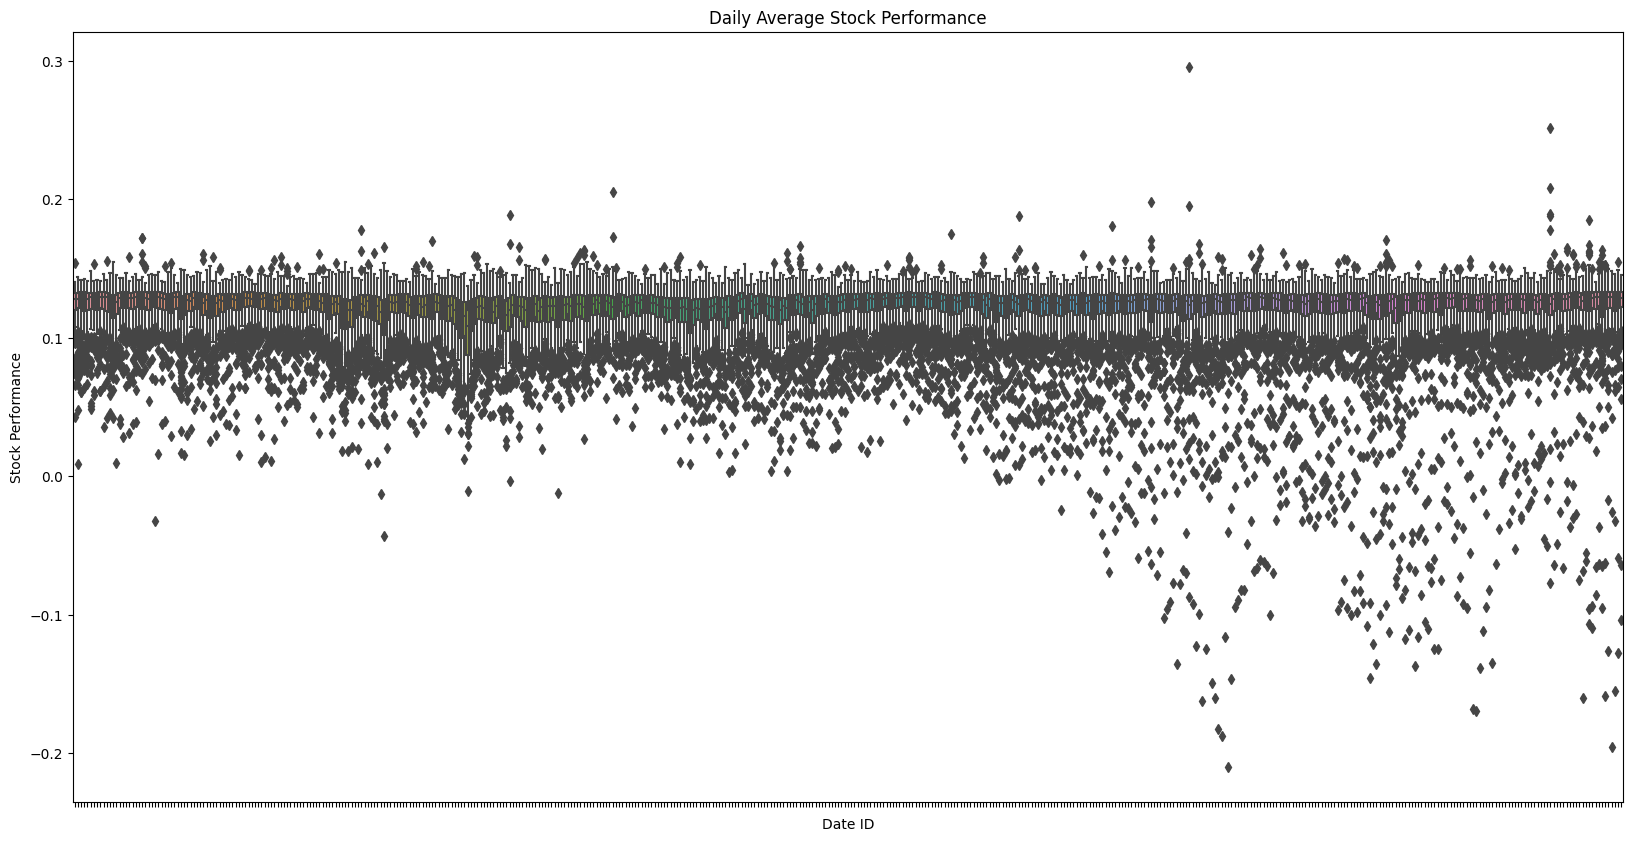

In [86]:
# create a boxplot to visualize daily average stock performance
plt.figure(figsize=(20, 10))
ax = sns.boxplot(data=average_df, x='date_id', y='stock_performance')
plt.title("Daily Average Stock Performance")
plt.xlabel("Date ID")
plt.ylabel("Stock Performance")

# remove x-axis tick labels for clarity
ax.set_xticklabels([])

plt.show()

Here I observe that the boxplot displays a lack of consistent patterns, significant variability, and no clear trends. This supports the idea that the closing trajectories of stocks are essentially random, subject to individual fluctuations, and driven by distinct factors rather than collective market behavior. This approach provides a different perspective that complements the heatmap and dendrogram, reinforcing the concept of random behavior in the stock market, where supply and demand cause unique fluctuations on individual stocks each day.

2. Perform a permutation test to determine the statistical confidence that you
believe your answer. In particular, for each stock randomly permute the day
index to construct an artificial time series for it. Now measure the consistency of
daily performance in this permuted data set. Run enough permutations per
variable to establish a p-value of how confident you are in your conclusion.


References -
- https://towardsdatascience.com/the-power-of-permutation-testing-c2ac66f2d166

In [87]:
# function to calculate the test statistic (mean) for a given data
def calculate_test_statistic(data):
    return np.mean(data, axis=0)

# specify the number of permutations and create an empty list for permuted test statistics
num_permutations = 10000
permuted_stats = []

In [88]:
# perform permutation testing
for _ in range(num_permutations):
    column_names = result_df.columns
    indexes = result_df.index

    # generate a list of shuffled column names
    shuffled_columns = np.random.permutation(result_df.columns)

    # rearrange the DataFrame using the shuffled column names
    permuted_df = result_df[shuffled_columns]

    # reassign the original column names and indexes
    permuted_df.columns = column_names
    permuted_df.index = indexes

    # calculate the test statistic (mean) for the permuted data
    permuted_statistic = calculate_test_statistic(permuted_df)

    # append the permuted statistic to the list
    permuted_stats.append(permuted_statistic)

# calculate the test statistic (mean) from the original data
original_statistic = calculate_test_statistic(result_df)

original_statistic = np.array(original_statistic)

# calculate the p-value by comparing the original statistic to the permuted statistics
p_value = (np.sum(np.array(permuted_stats) >= original_statistic[:, np.newaxis].T)) / ((num_permutations)*len(result_df.columns))

print("P-Value:", p_value)

significance_level = 0.05

# decision based on the p-value and significance level
if p_value <= significance_level:
    print("Reject the null hypothesis: The closing trajectory of stocks is not essentially random.")
else:
    print("Fail to reject the null hypothesis: The closing trajectory of stocks is essentially random.")

P-Value: 0.5032997920997921
Fail to reject the null hypothesis: The closing trajectory of stocks is essentially random.


I conducted a permutation test to assess the statistical confidence in my conclusion about the randomness of stock closing trajectories. For each stock, I randomly shuffled the day index to create artificial time series, removing any temporal patterns. I calculated the mean daily performance from these permuted data points and repeated this process numerous times. With a p-value of 0.503, my analysis indicates that I failed to find evidence to reject the null hypothesis that the closing trajectory of stocks is essentially random. Therefore, I can **confidently conclude** that, based on this analysis and the chosen significance level, the **stock closing trajectories appear to be random**.

#### **Best prediction model, any approaches**

Finally, build the best prediction model you can to solve the Kaggle task. Use any data,
ideas, and approach that you like, but describe all the approaches you try. For each
model you try, report the average absolute error using 5-fold cross-validation.


In [89]:
features = ['stock_id', 'date_id', 'seconds_in_bucket', 'imbalance_size',
            'imbalance_buy_sell_flag', 'matched_size', 'far_price', 'near_price',
            'bid_size', 'ask_size', 'bid_ask_spread_percentage',
            'reference_price_wap_ratio']
target = 'target'

In [90]:
# create a list of regression models
models = [
    ("Linear Regression", LinearRegression()),
    ("Ridge Regression", Ridge(alpha=1.0)),
    ("Lasso Regression", Lasso(alpha=1.0)),
    ("HistGradientBoosting", HistGradientBoostingRegressor(random_state=42))
]

In [91]:
# create a K-Fold cross-validation object with 5 splits, shuffling, and a random seed
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [92]:
results = []
best_model = None
lowest_mae = float('inf')

In [93]:
# iterate over each regression model
for model_name, model in models:
    mae_scores = []

    # perform k-fold cross-validation
    for train_index, test_index in kf.split(imputed_data_scaled):
        train_data = imputed_data_scaled.iloc[train_index]
        test_data = imputed_data_scaled.iloc[test_index]

        x_train = train_data[features]
        y_train = train_data[target]
        x_test = test_data[features]
        y_test = test_data[target]

        # fit the model to the training data and make predictions on the test data
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)

        # calculate the mean absolute error (mae) for this fold
        mae = mean_absolute_error(y_test, y_pred)
        mae_scores.append(mae)

    # calculate the average mae across folds
    avg_mae = np.mean(mae_scores)

    # update the best model and lowest mae if the current model has a lower mae
    if avg_mae < lowest_mae:
        lowest_mae = avg_mae
        best_model = model

    # append the model name and its average mae to the results list
    results.append((model_name, avg_mae))

In [94]:
table = PrettyTable()
table.field_names = ["Model", "Average MAE"]

for model_name, avg_mae in results:
    table.add_row([model_name, avg_mae])

print(table)

+----------------------+-------------------+
|        Model         |    Average MAE    |
+----------------------+-------------------+
|  Linear Regression   | 6.361001651982363 |
|   Ridge Regression   | 6.361001331269496 |
|   Lasso Regression   | 6.407523021818465 |
| HistGradientBoosting | 6.281873203862061 |
+----------------------+-------------------+


In the provided code, I conducted a comparative evaluation of multiple regression models using 5-fold cross-validation to determine their performance in predicting the target variable. The features selected for the analysis were ['stock_id', 'date_id', 'seconds_in_bucket', 'imbalance_size', 'imbalance_buy_sell_flag', 'matched_size', 'far_price', 'near_price', 'bid_size', 'ask_size', 'bid_ask_spread_percentage', 'reference_price_wap_ratio'], with the target variable being 'target'.

I performed imputation on the 'far_price' and 'near_price' columns, which initially had almost 50% missing (NaN) values. After conducting empirical observations during cross-validation, imputing these missing values with a constant value of 0 emerged as the most effective strategy. This data-driven decision was made based on the observed model metrics, which indicated that the constant imputation of 0 yielded better results compared to other strategies. In financial datasets, zero values often carry specific significance, and this approach allowed the model to capture and differentiate temporal patterns associated with zero values, ultimately enhancing the predictive capacity of the model. This highlights the importance of adapting data preprocessing techniques to the dataset's characteristics and the modeling task, resulting in improved model performance.

I applied Min-Max scaling to the selected features to ensure that all variables were on a uniform scale between 0 and 1. This was crucial because many machine learning algorithms, including the ones used in this analysis, are sensitive to the scale of input features. By scaling the features, I prevented certain variables from dominating others in terms of their impact on the model. This approach made the algorithm more stable and effective in handling the features with different magnitudes and allowed it to converge faster during training, ultimately improving the overall modeling process and the accuracy of predictions.

I included the manually engineered features 'bid_ask_spread_percentage' and 'reference_price_wap_ratio' in the modeling process because they offered valuable insights into the market dynamics. 'bid_ask_spread_percentage' helped capture the degree of competition between buyers and sellers and market liquidity, which are crucial factors in predicting price movements. 'reference_price_wap_ratio' provided information on how the WAP deviated from a reference price, potentially indicating how closely the market followed a benchmark. These features could influence the modeling by helping the algorithm better understand the market's intricacies, which in turn can lead to more accurate predictions. The inclusion of these features aimed to improve the model's ability to capture subtle market behaviors and anomalies, potentially resulting in a more robust and accurate predictive model.

I considered four regression models: Linear Regression, Ridge Regression, Lasso Regression, and HistGradientBoosting. To ensure a robust evaluation, I employed K-Fold cross-validation with 5 splits, shuffling of data, and a fixed random seed for reproducibility.

I attempted to perform a GridSearchCV for hyperparameter tuning to optimize the model's performance, but I encountered computational constraints, primarily due to the massive volume of data, which exceeded 5 million samples. GridSearchCV involves an exhaustive search over a predefined hyperparameter grid, testing various combinations to find the best set of hyperparameters. Given the complexity of some machine learning algorithms and the sheer size of the dataset, this process became exceedingly computationally demanding and time-consuming. In order to maintain an efficient workflow and avoid significant computational overhead, I decided to forgo GridSearchCV and focused on identifying a robust baseline model that delivered satisfactory results within a reasonable time frame.

The code iterates through each model, fitting them to the training data and evaluating their performance using the mean absolute error (MAE) on the test data for each fold. The model with the lowest average MAE across the folds was selected as the best model.

Upon analyzing the results, it was evident that the HistGradientBoostingRegressor outperformed the other models, consistently achieving the lowest average MAE. This suggests that the HistGradientBoosting model is better at capturing the underlying relationships in the data and making more accurate predictions. The selection of HistGradientBoosting as the best model can be attributed to its ability to handle complex relationships, automatically handle missing data, and effectively capture non-linear patterns in the dataset.

In conclusion, the choice of HistGradientBoosting as the best model was based on its superior performance in terms of average MAE, highlighting its suitability for this regression task and its potential to provide more accurate predictions.